# Домашнее задание 3: Классификация 128x128 + U-Net c бэкбоном

In [1]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import zipfile

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


--2025-12-14 17:32:06--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-12-14 17:32:06--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  73.0MB/s    in 4.0s    

2025-12-14 17:32:10 (59.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



## Часть 1. Классификатор 128×128

### Загрузка данных датасета


In [3]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, splits=['train'], transform=None):
        self.root_dir = root_dir
        self.splits = splits
        self.transform = transform
        zip_path = f'{root_dir}.zip'
        temp_extract = "./_temp_extract"

        if not os.path.exists(root_dir):
          if not os.path.exists(zip_path):
              print("File ", zip_path, "not found.")
          else:
              with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                  zip_ref.extractall(temp_extract)
                  inner_folder = os.path.join(temp_extract, "tiny-imagenet-200")

                  os.makedirs(self.root_dir, exist_ok=True)
                  for item in os.listdir(inner_folder):
                      src = os.path.join(inner_folder, item)
                      dst = os.path.join(self.root_dir, item)
                      if os.path.isdir(src):
                          shutil.copytree(src, dst, dirs_exist_ok=True)
                      else:
                          shutil.copy2(src, dst)
                  shutil.rmtree(temp_extract)
                  print("Archive ", zip_path, "unpacked into ", root_dir)

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if 'train' in self.splits:
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        if 'val' in self.splits:
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class TinyImageNetSubDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, splits=['train', 'val'], transform=transform)

print("Train size: ", len(train_dataset))
print("Classes: ", len(train_dataset.class_names))

Train size:  110000
Classes:  200


Разделение выборки на тренировочную и валидационную

In [4]:
all_samples = train_dataset.samples
X = [x for x, y in all_samples]
y = [y for x, y in all_samples]

print("Prepared ", len(X), "samples with", len(set(y)), "classes")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print("Stratified split:")
print("Train: ", len(train_split_stratified),  "samples")
print("Val: ", len(val_split_stratified), "samples")

Prepared  110000 samples with 200 classes
Stratified split:
Train:  88000 samples
Val:  22000 samples


Ограничение датасетов на 10 классов

In [5]:
selected_wnids = ['n02123045', 'n01443537',  'n01629819', 'n02206856',  'n04285008',
                  'n07749582', 'n09246464', 'n03085013', 'n02823428', 'n04008634']
selected_classes = [train_dataset.class_names.index(wnid) for wnid in selected_wnids]


subset_train_samples = [s for s in train_split_stratified if s[1] in selected_classes]
subset_val_samples = [s for s in val_split_stratified if s[1] in selected_classes]

print("Using ", len(subset_train_samples),  " train and ", len(subset_val_samples), "val of images from ", len(selected_classes), " classes")

class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)

train_transform = transforms.Compose([
    transforms.Resize((136, 136)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_subset_dataset = TinyImageNetSubDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = TinyImageNetSubDataset(subset_val_samples, transform=transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False, drop_last=True)

Using  4400  train and  1100 val of images from  10  classes


In [6]:
with open(os.path.join(root, 'words.txt'), 'r') as f:
    wnid_to_word = {}
    for line in f:
        wnid, word = line.strip().split('\t', 1)
        wnid_to_word[wnid] = word

class_names_human = [wnid_to_word[wnid].split(",")[0] for wnid in selected_wnids]

### Модель

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        match activation:
            case "relu":
                self.activation = nn.ReLU(inplace=True)
            case "leakyrelu":
                self.activation = nn.LeakyReLU(inplace=True)
            case "elu":
                self.activation = nn.ELU(inplace=True)
            case "gelu":
                self.activation = nn.GELU()
            case _:
                self.activation = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if (in_channels != out_channels) or (downsample != None):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x_in = self.downsample(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += x_in
        out = self.activation(out)
        return out

In [8]:
class ModelResnet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32, activation="gelu")
        self.basic_block_2_0 = BasicBlock(32, 64, 2, activation="gelu")
        self.basic_block_3_0 = BasicBlock(64, 128, 2, activation="gelu")
        self.basic_block_4_0 = BasicBlock(128, 256, 2, activation="gelu")
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)
        x = self.basic_block_4_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [9]:
modelResnet = ModelResnet()
print("Total params N: ", sum(p.numel() for p in modelResnet.parameters()))
test_input = torch.randn(1, 3, 64, 64)
output = modelResnet(test_input)
print(output.shape)

Total params N:  1219850
torch.Size([1, 10])


### Скрипт обучения и визуализации


In [10]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predicted = model(data)

        loss = criterion(predicted, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        total += target.size(0)
        correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

In [11]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          predicted = model(data)

          loss = criterion(predicted, target)
          running_loss += loss.item()

          total += target.size(0)
          correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(val_loader), 100 * correct / total

In [12]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_path='best_model.pth'):

    print("Обучение на ", num_epochs,  " epochs")

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    model = model.to(device)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch ", epoch+1, "/", num_epochs)

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print("Train Loss: ", train_loss, "Train Acc: ", train_acc)
        print("Val Loss: ", val_loss, "Val Acc: ", val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with accuracy:  ", val_acc)


    return history



Визуализация

In [13]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax1.plot(np.arange(1, len(history['val_acc'])-1, 1), np.convolve(history['val_acc'], np.ones(3)/3, mode='valid'), label='Smooth val acc', color='red', alpha=0.3 )
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Validation Loss', color='red')
    ax2.plot(np.arange(1, len(history['val_loss'])-1, 1), np.convolve(history['val_loss'], np.ones(3)/3, mode='valid'), label='Smooth val loss', color='red', alpha=0.3 )
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)


    plt.tight_layout()
    plt.show()

### Обучение

In [14]:
optimizer = torch.optim.Adam(modelResnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_resnet = train_model(
    model=modelResnet,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40,
    model_path="model_resnet.pth"
)

cuda
Обучение на  40  epochs
Epoch  1 / 40


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


Train Loss:  1.9270051349611843 Train Acc:  30.124080882352942
Val Loss:  1.7570750573102165 Val Acc:  35.845588235294116
Saved best model with accuracy:   35.845588235294116
Epoch  2 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.08it/s]


Train Loss:  1.710104476003086 Train Acc:  38.30422794117647
Val Loss:  1.926021884469425 Val Acc:  36.12132352941177
Saved best model with accuracy:   36.12132352941177
Epoch  3 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.89it/s]


Train Loss:  1.5895731466657974 Train Acc:  44.71507352941177
Val Loss:  1.5994373559951782 Val Acc:  47.24264705882353
Saved best model with accuracy:   47.24264705882353
Epoch  4 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.30it/s]


Train Loss:  1.4700659653719734 Train Acc:  49.24172794117647
Val Loss:  1.5408332558239208 Val Acc:  47.150735294117645
Epoch  5 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.96it/s]


Train Loss:  1.394135734614204 Train Acc:  53.14797794117647
Val Loss:  1.301251355339499 Val Acc:  56.61764705882353
Saved best model with accuracy:   56.61764705882353
Epoch  6 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.47it/s]


Train Loss:  1.305781297823962 Train Acc:  54.044117647058826
Val Loss:  1.4385955824571497 Val Acc:  53.58455882352941
Epoch  7 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.18it/s]


Train Loss:  1.2360442648915684 Train Acc:  58.203125
Val Loss:  1.2531482402016134 Val Acc:  59.00735294117647
Saved best model with accuracy:   59.00735294117647
Epoch  8 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.50it/s]


Train Loss:  1.1760704517364502 Train Acc:  60.409007352941174
Val Loss:  1.2455811184995316 Val Acc:  59.19117647058823
Saved best model with accuracy:   59.19117647058823
Epoch  9 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s]


Train Loss:  1.128709911423571 Train Acc:  62.04044117647059
Val Loss:  1.1698705483885372 Val Acc:  61.580882352941174
Saved best model with accuracy:   61.580882352941174
Epoch  10 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.58it/s]


Train Loss:  1.0930499539655798 Train Acc:  63.028492647058826
Val Loss:  1.2293797485968645 Val Acc:  61.213235294117645
Epoch  11 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.95it/s]


Train Loss:  1.0342587215058945 Train Acc:  65.51011029411765
Val Loss:  1.2257919802385218 Val Acc:  60.9375
Epoch  12 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s]


Train Loss:  0.9914762088481117 Train Acc:  67.5091911764706
Val Loss:  1.0393901116707747 Val Acc:  65.99264705882354
Saved best model with accuracy:   65.99264705882354
Epoch  13 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.15it/s]


Train Loss:  0.9430766140713411 Train Acc:  69.27849264705883
Val Loss:  1.5062563489465153 Val Acc:  57.2610294117647
Epoch  14 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.06it/s]


Train Loss:  0.9175337176112568 Train Acc:  70.7720588235294
Val Loss:  1.1041728012702043 Val Acc:  63.970588235294116
Epoch  15 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.25it/s]


Train Loss:  0.8819063463631798 Train Acc:  70.97886029411765
Val Loss:  1.0226204184924854 Val Acc:  66.54411764705883
Saved best model with accuracy:   66.54411764705883
Epoch  16 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.15it/s]


Train Loss:  0.8754503043258891 Train Acc:  71.00183823529412
Val Loss:  1.0164916550411898 Val Acc:  66.81985294117646
Saved best model with accuracy:   66.81985294117646
Epoch  17 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.00it/s]


Train Loss:  0.8143422572928316 Train Acc:  73.3685661764706
Val Loss:  0.9285809818436118 Val Acc:  70.86397058823529
Saved best model with accuracy:   70.86397058823529
Epoch  18 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.19it/s]


Train Loss:  0.7977684429463219 Train Acc:  74.08088235294117
Val Loss:  1.078760059440837 Val Acc:  66.17647058823529
Epoch  19 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.60it/s]


Train Loss:  0.7829220010077252 Train Acc:  74.31066176470588
Val Loss:  0.8618610466227812 Val Acc:  71.78308823529412
Saved best model with accuracy:   71.78308823529412
Epoch  20 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.20it/s]


Train Loss:  0.779108505915193 Train Acc:  74.2876838235294
Val Loss:  1.0792077534339006 Val Acc:  64.33823529411765
Epoch  21 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.69it/s]


Train Loss:  0.7335964090683881 Train Acc:  75.73529411764706
Val Loss:  1.128759065095116 Val Acc:  65.1654411764706
Epoch  22 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.08it/s]


Train Loss:  0.7470935841693598 Train Acc:  75.43658088235294
Val Loss:  0.8816725506502039 Val Acc:  72.70220588235294
Saved best model with accuracy:   72.70220588235294
Epoch  23 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.15it/s]


Train Loss:  0.6948241731699776 Train Acc:  76.90716911764706
Val Loss:  0.9953073999461006 Val Acc:  69.48529411764706
Epoch  24 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.06it/s]


Train Loss:  0.6740695790332907 Train Acc:  77.6654411764706
Val Loss:  0.9884391602347878 Val Acc:  69.11764705882354
Epoch  25 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.17it/s]


Train Loss:  0.6536810034338165 Train Acc:  78.53860294117646
Val Loss:  0.8424389362335205 Val Acc:  73.71323529411765
Saved best model with accuracy:   73.71323529411765
Epoch  26 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s]


Train Loss:  0.6553601175546646 Train Acc:  78.53860294117646
Val Loss:  0.8500259728992686 Val Acc:  73.34558823529412
Epoch  27 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.24it/s]


Train Loss:  0.6484641288133228 Train Acc:  79.25091911764706
Val Loss:  0.7462829929940841 Val Acc:  75.64338235294117
Saved best model with accuracy:   75.64338235294117
Epoch  28 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.96it/s]


Train Loss:  0.6072988444391418 Train Acc:  80.81341911764706
Val Loss:  0.9213082054082085 Val Acc:  72.42647058823529
Epoch  29 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.23it/s]


Train Loss:  0.5885294667061638 Train Acc:  80.76746323529412
Val Loss:  0.9076594955780927 Val Acc:  70.95588235294117
Epoch  30 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.20it/s]


Train Loss:  0.5803590096971568 Train Acc:  80.7904411764706
Val Loss:  0.8493607500020195 Val Acc:  72.42647058823529
Epoch  31 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.23it/s]


Train Loss:  0.5721681814859895 Train Acc:  81.75551470588235
Val Loss:  0.8449561069993412 Val Acc:  74.08088235294117
Epoch  32 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.78it/s]


Train Loss:  0.5509610136642176 Train Acc:  82.03125
Val Loss:  0.8380453902132371 Val Acc:  72.3345588235294
Epoch  33 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.21it/s]


Train Loss:  0.5654242599711699 Train Acc:  81.25
Val Loss:  0.6770085236605476 Val Acc:  78.95220588235294
Saved best model with accuracy:   78.95220588235294
Epoch  34 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.27it/s]


Train Loss:  0.5435128299628987 Train Acc:  82.14613970588235
Val Loss:  0.7796475571744582 Val Acc:  74.5404411764706
Epoch  35 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.34it/s]


Train Loss:  0.5180078924578779 Train Acc:  82.67463235294117
Val Loss:  0.8228011026101953 Val Acc:  74.35661764705883
Epoch  36 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.21it/s]


Train Loss:  0.518171225400532 Train Acc:  82.85845588235294
Val Loss:  0.9914939438595491 Val Acc:  70.7720588235294
Epoch  37 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s]


Train Loss:  0.5042863979059107 Train Acc:  83.57077205882354
Val Loss:  1.0142156937543083 Val Acc:  73.16176470588235
Epoch  38 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 11.12it/s]


Train Loss:  0.4829466255272136 Train Acc:  84.71966911764706
Val Loss:  0.7683794673751382 Val Acc:  75.18382352941177
Epoch  39 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.66it/s]


Train Loss:  0.47882262310561013 Train Acc:  84.14522058823529
Val Loss:  0.8742466744254617 Val Acc:  73.71323529411765
Epoch  40 / 40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.92it/s]

Train Loss:  0.46405933315263076 Train Acc:  84.765625
Val Loss:  0.7051942401072558 Val Acc:  77.6654411764706


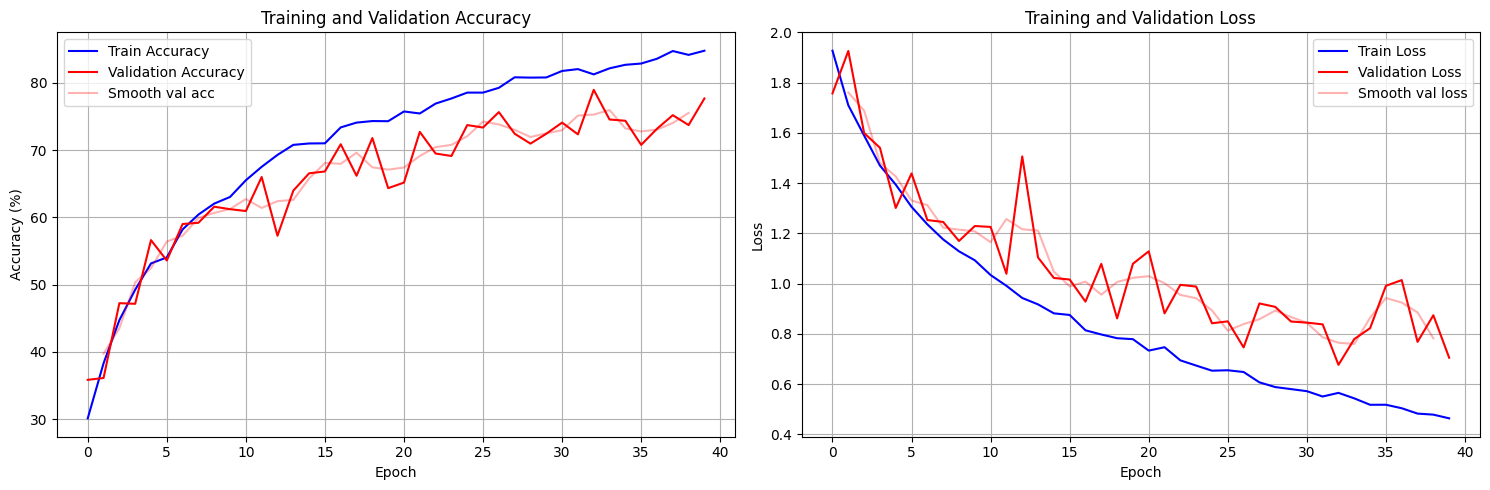

In [15]:
plot_training_history(history_resnet)

**Результы обучения resnet:** на 33 эпохе модель достигла Val Accuracy 90.73%

## Часть 2. Базовая U-Net на "Луне"

### Загрузка данных датасета


In [16]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)

        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # remove render for masks
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # BGR->RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 0-background 1-rocks
        mask = (mask > 0).astype(np.float32)

        # augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

In [17]:
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2584448850.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


In [18]:
DATA_ROOT = "MOON_SEGMENTATION_BINARY"
zip_path = f'{DATA_ROOT}.zip'
temp_extract = "./_temp_extract"

In [19]:
if not os.path.exists(DATA_ROOT):
    if not os.path.exists(zip_path):
        print("File ", zip_path, "not found.")
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_extract)
            inner_folder = os.path.join(temp_extract, "MOON_SEGMENTATION_BINARY")

            os.makedirs(DATA_ROOT, exist_ok=True)
            for item in os.listdir(inner_folder):
                src = os.path.join(inner_folder, item)
                dst = os.path.join(DATA_ROOT, item)
                if os.path.isdir(src):
                    shutil.copytree(src, dst, dirs_exist_ok=True)
                else:
                    shutil.copy2(src, dst)
            shutil.rmtree(temp_extract)
            print("Archive ", zip_path, "unpacked into ", DATA_ROOT)

File  MOON_SEGMENTATION_BINARY.zip not found.


In [23]:
!unzip -q MOON_SEGMENTATION_BINARY.zip

In [24]:
images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print("Total images: ", len(all_images))

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print("Train: ", len(train_ids), " images")
print("Val: ", len(val_ids), " images")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("train Batches: ", len(train_loader))
print("val Batches: ", len(val_loader))

Total images:  100
Train:  80  images
Val:  20  images
train Batches:  20
val Batches:  5


### Модель

In [25]:
class LayerConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LayerConv, self).__init__()
        self.layer_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layer_conv(x)

In [26]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(LayerConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = LayerConv(features[-1], features[-1] * 2)

        in_channels_up = features[-1] * 2
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(in_channels_up, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                LayerConv(feature * 2, feature)
            )
            in_channels_up = feature


        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid())

        total_params = sum(p.numel() for p in self.parameters())
        print("Params: ", total_params)
        print("encoder levels: ", len(features))
        print("channel conf: ", features)

    def forward(self, x):
        skip_connections = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        return output

In [27]:
model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print("   IN:  ", test_input.shape)
print("   OUT: ", test_output.shape)

Params:  2466657
encoder levels:  4
channel conf:  [32, 64, 128, 192]
   IN:   torch.Size([1, 3, 128, 128])
   OUT:  torch.Size([1, 1, 128, 128])


### Скрипт обучения и метрики

In [28]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)

    return dice.item()

def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()

    return (correct / total).item()

In [29]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(train_loader, desc="Training")

    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

        running_loss += loss.item()
        running_dice += dice
        running_iou += iou

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })

    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)

    return avg_loss, avg_dice, avg_iou

In [30]:
def validate_epoch(model, val_loader, criterion, device):

    model.eval()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)

            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })

    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)

    return avg_loss, avg_dice, avg_iou, avg_acc

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print("Epoch ", epoch+1, "/", num_epochs)

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print("\n Epoch res ", epoch+1)
        print("  Train - Loss: ", train_loss, " Dice: ", train_dice, " IoU: ", train_iou)
        print("  Val   - Loss: ", val_loss, " Dice: ", val_dice, " IoU: ", val_iou, " Acc: ", val_acc)
        print("  LR: ", current_lr)

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print("  Saved best model! Dice: ", val_dice)
    print("Best Val Dice: ", best_val_dice)

    return history

### Обучение

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("  using dev: ", device)
unet_model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5,patience=3,)

history = train_model(
    model=unet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_unet.pth'
)

  using dev:  cuda
Params:  2466657
encoder levels:  4
channel conf:  [32, 64, 128, 192]
Epoch  1 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.32it/s, loss=0.8165, dice=0.3873, iou=0.2401, acc=0.8246]



 Epoch res  1
  Train - Loss:  0.8534980326890945  Dice:  0.25928004253655673  IoU:  0.15303875571116804
  Val   - Loss:  0.8120744705200196  Dice:  0.39034995436668396  IoU:  0.24319373965263366  Acc:  0.7609161376953125
  LR:  0.0001
  Saved best model! Dice:  0.39034995436668396
Epoch  2 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s, loss=0.7817, dice=0.4510, iou=0.2911, acc=0.8051]



 Epoch res  2
  Train - Loss:  0.8302802860736846  Dice:  0.3198485909029841  IoU:  0.1984285047277808
  Val   - Loss:  0.7759461879730225  Dice:  0.4635829746723175  IoU:  0.3022048592567444  Acc:  0.738494873046875
  LR:  0.0001
  Saved best model! Dice:  0.4635829746723175
Epoch  3 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.97it/s, loss=0.7683, dice=0.4557, iou=0.2951, acc=0.8380]



 Epoch res  3
  Train - Loss:  0.8274483144283294  Dice:  0.31245227754116056  IoU:  0.1933870768174529
  Val   - Loss:  0.7604540228843689  Dice:  0.49338682293891906  IoU:  0.32806201577186583  Acc:  0.815557861328125
  LR:  0.0001
  Saved best model! Dice:  0.49338682293891906
Epoch  4 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.13it/s, loss=0.7596, dice=0.4359, iou=0.2787, acc=0.8467]



 Epoch res  4
  Train - Loss:  0.8185830026865005  Dice:  0.33286250587552785  IoU:  0.20617326786741613
  Val   - Loss:  0.7467795014381409  Dice:  0.5008876323699951  IoU:  0.3355854868888855  Acc:  0.8415130615234375
  LR:  0.0001
  Saved best model! Dice:  0.5008876323699951
Epoch  5 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s, loss=0.7569, dice=0.4415, iou=0.2833, acc=0.7804]



 Epoch res  5
  Train - Loss:  0.8114006847143174  Dice:  0.3483177155256271  IoU:  0.21571832858026027
  Val   - Loss:  0.7611034989356995  Dice:  0.4410153925418854  IoU:  0.283166778087616  Acc:  0.7041717529296875
  LR:  0.0001
Epoch  6 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s, loss=0.7520, dice=0.4464, iou=0.2874, acc=0.7718]



 Epoch res  6
  Train - Loss:  0.8056595116853714  Dice:  0.364186542481184  IoU:  0.22725543677806853
  Val   - Loss:  0.7481111764907837  Dice:  0.46713809967041015  IoU:  0.30514622330665586  Acc:  0.7358306884765625
  LR:  0.0001
Epoch  7 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s, loss=0.7606, dice=0.4271, iou=0.2716, acc=0.8670]



 Epoch res  7
  Train - Loss:  0.8056369751691819  Dice:  0.3520006913691759  IoU:  0.22006578426808118
  Val   - Loss:  0.7471097946166992  Dice:  0.48221683502197266  IoU:  0.32115817368030547  Acc:  0.85386962890625
  LR:  0.0001
Epoch  8 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.52it/s, loss=0.7522, dice=0.4750, iou=0.3115, acc=0.8334]



 Epoch res  8
  Train - Loss:  0.7977670341730118  Dice:  0.38387111350893977  IoU:  0.24360866248607635
  Val   - Loss:  0.7396591901779175  Dice:  0.5234812676906586  IoU:  0.35581382513046267  Acc:  0.8245269775390625
  LR:  0.0001
  Saved best model! Dice:  0.5234812676906586
Epoch  9 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.12it/s, loss=0.7518, dice=0.4461, iou=0.2871, acc=0.7788]



 Epoch res  9
  Train - Loss:  0.8010278046131134  Dice:  0.3491683263331652  IoU:  0.21699078269302846
  Val   - Loss:  0.7396674513816833  Dice:  0.4847877860069275  IoU:  0.32020201683044436  Acc:  0.761334228515625
  LR:  0.0001
Epoch  10 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s, loss=0.7385, dice=0.4929, iou=0.3271, acc=0.8206]



 Epoch res  10
  Train - Loss:  0.7893982946872711  Dice:  0.3860239751636982  IoU:  0.24603434838354588
  Val   - Loss:  0.7272538661956787  Dice:  0.5275497198104858  IoU:  0.35912200808525085  Acc:  0.8092864990234375
  LR:  0.0001
  Saved best model! Dice:  0.5275497198104858
Epoch  11 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.23it/s, loss=0.7347, dice=0.4894, iou=0.3240, acc=0.8431]



 Epoch res  11
  Train - Loss:  0.7922851711511611  Dice:  0.3730123572051525  IoU:  0.23477148711681367
  Val   - Loss:  0.722397792339325  Dice:  0.5208935022354126  IoU:  0.3532404363155365  Acc:  0.824627685546875
  LR:  0.0001
Epoch  12 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.84it/s, loss=0.7360, dice=0.4802, iou=0.3160, acc=0.8003]



 Epoch res  12
  Train - Loss:  0.7852268010377884  Dice:  0.380143041908741  IoU:  0.24142446219921113
  Val   - Loss:  0.7275372743606567  Dice:  0.5072941899299621  IoU:  0.340137779712677  Acc:  0.7609954833984375
  LR:  0.0001
Epoch  13 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s, loss=0.7253, dice=0.5377, iou=0.3677, acc=0.8491]



 Epoch res  13
  Train - Loss:  0.7841431587934494  Dice:  0.3872281417250633  IoU:  0.24632226638495922
  Val   - Loss:  0.7204795360565186  Dice:  0.5495466589927673  IoU:  0.3792523741722107  Acc:  0.8228759765625
  LR:  0.0001
  Saved best model! Dice:  0.5495466589927673
Epoch  14 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s, loss=0.7190, dice=0.5234, iou=0.3545, acc=0.8400]



 Epoch res  14
  Train - Loss:  0.7733906477689743  Dice:  0.4156781733036041  IoU:  0.26864176280796526
  Val   - Loss:  0.7111844658851624  Dice:  0.5440454959869385  IoU:  0.37450498938560484  Acc:  0.8269012451171875
  LR:  0.0001
Epoch  15 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.85it/s, loss=0.7124, dice=0.5369, iou=0.3670, acc=0.8541]



 Epoch res  15
  Train - Loss:  0.7793789714574814  Dice:  0.3845973365008831  IoU:  0.24378906190395355
  Val   - Loss:  0.7057891488075256  Dice:  0.558749508857727  IoU:  0.38825499415397646  Acc:  0.83101806640625
  LR:  0.0001
  Saved best model! Dice:  0.558749508857727
Epoch  16 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s, loss=0.7203, dice=0.4738, iou=0.3104, acc=0.8008]



 Epoch res  16
  Train - Loss:  0.7784025579690933  Dice:  0.38320239037275317  IoU:  0.24363912492990494
  Val   - Loss:  0.7061737298965454  Dice:  0.5218374013900757  IoU:  0.35376882553100586  Acc:  0.7984405517578125
  LR:  0.0001
Epoch  17 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.88it/s, loss=0.6979, dice=0.5513, iou=0.3806, acc=0.8709]



 Epoch res  17
  Train - Loss:  0.7752608060836792  Dice:  0.3874705947935581  IoU:  0.245801449008286
  Val   - Loss:  0.6856830596923829  Dice:  0.5730029106140136  IoU:  0.40215984582901  Acc:  0.864752197265625
  LR:  0.0001
  Saved best model! Dice:  0.5730029106140136
Epoch  18 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.96it/s, loss=0.6916, dice=0.5698, iou=0.3984, acc=0.8770]



 Epoch res  18
  Train - Loss:  0.7659465283155441  Dice:  0.41391447111964225  IoU:  0.26807083524763586
  Val   - Loss:  0.6828656196594238  Dice:  0.5716794729232788  IoU:  0.40106990933418274  Acc:  0.8627960205078125
  LR:  0.0001
Epoch  19 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s, loss=0.6938, dice=0.5570, iou=0.3860, acc=0.8621]



 Epoch res  19
  Train - Loss:  0.7588884651660919  Dice:  0.42476586177945136  IoU:  0.2794756624847651
  Val   - Loss:  0.6880095481872559  Dice:  0.5758210062980652  IoU:  0.4048763573169708  Acc:  0.8423858642578125
  LR:  0.0001
  Saved best model! Dice:  0.5758210062980652
Epoch  20 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.76it/s, loss=0.6902, dice=0.5702, iou=0.3988, acc=0.8625]



 Epoch res  20
  Train - Loss:  0.7590507864952087  Dice:  0.4208897851407528  IoU:  0.2720973860472441
  Val   - Loss:  0.6835230231285095  Dice:  0.5757129907608032  IoU:  0.4050052046775818  Acc:  0.85594482421875
  LR:  0.0001
Epoch  21 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.63it/s, loss=0.6814, dice=0.5697, iou=0.3983, acc=0.8638]



 Epoch res  21
  Train - Loss:  0.753268051147461  Dice:  0.43757768273353576  IoU:  0.2869548790156841
  Val   - Loss:  0.6764173030853271  Dice:  0.5724088668823242  IoU:  0.40199559926986694  Acc:  0.845721435546875
  LR:  0.0001
Epoch  22 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.99it/s, loss=0.7074, dice=0.5302, iou=0.3607, acc=0.8443]



 Epoch res  22
  Train - Loss:  0.7568751484155655  Dice:  0.4191347286105156  IoU:  0.27755409069359305
  Val   - Loss:  0.6909122705459595  Dice:  0.5660222411155701  IoU:  0.3956527769565582  Acc:  0.8446136474609375
  LR:  0.0001
Epoch  23 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s, loss=0.6867, dice=0.5590, iou=0.3879, acc=0.8774]



 Epoch res  23
  Train - Loss:  0.7503169625997543  Dice:  0.4379517391324043  IoU:  0.28911357261240483
  Val   - Loss:  0.6837574124336243  Dice:  0.5464416682720185  IoU:  0.3777075529098511  Acc:  0.86085205078125
  LR:  5e-05
Epoch  24 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s, loss=0.6807, dice=0.5663, iou=0.3950, acc=0.8622]



 Epoch res  24
  Train - Loss:  0.7479441553354264  Dice:  0.43568331003189087  IoU:  0.2824798382818699
  Val   - Loss:  0.6758597493171692  Dice:  0.5724582314491272  IoU:  0.40179823637008666  Acc:  0.855535888671875
  LR:  5e-05
Epoch  25 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.03it/s, loss=0.6837, dice=0.5635, iou=0.3922, acc=0.8727]



 Epoch res  25
  Train - Loss:  0.751778843998909  Dice:  0.4175346277654171  IoU:  0.2714211866259575
  Val   - Loss:  0.6719820499420166  Dice:  0.5874137043952942  IoU:  0.4165244519710541  Acc:  0.864080810546875
  LR:  5e-05
  Saved best model! Dice:  0.5874137043952942
Epoch  26 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s, loss=0.6813, dice=0.5419, iou=0.3717, acc=0.8509]



 Epoch res  26
  Train - Loss:  0.7571308881044387  Dice:  0.39869436621665955  IoU:  0.25621614009141924
  Val   - Loss:  0.6669011831283569  Dice:  0.573801577091217  IoU:  0.4030417263507843  Acc:  0.84056396484375
  LR:  5e-05
Epoch  27 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s, loss=0.6863, dice=0.5656, iou=0.3943, acc=0.8655]



 Epoch res  27
  Train - Loss:  0.7388337463140487  Dice:  0.45301343202590943  IoU:  0.3006809648126364
  Val   - Loss:  0.6738736629486084  Dice:  0.589858329296112  IoU:  0.419013512134552  Acc:  0.85789794921875
  LR:  5e-05
  Saved best model! Dice:  0.589858329296112
Epoch  28 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.85it/s, loss=0.6683, dice=0.5678, iou=0.3964, acc=0.8696]



 Epoch res  28
  Train - Loss:  0.7451177060604095  Dice:  0.42705291211605073  IoU:  0.27907007448375226
  Val   - Loss:  0.6593739271163941  Dice:  0.5884654998779297  IoU:  0.41760689616203306  Acc:  0.8539306640625
  LR:  5e-05
Epoch  29 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s, loss=0.6787, dice=0.5762, iou=0.4047, acc=0.8615]



 Epoch res  29
  Train - Loss:  0.7312129676342011  Dice:  0.47508305460214617  IoU:  0.3183110371232033
  Val   - Loss:  0.6713213682174682  Dice:  0.5896571993827819  IoU:  0.41882691979408265  Acc:  0.8450653076171875
  LR:  5e-05
Epoch  30 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.33it/s, loss=0.6803, dice=0.5772, iou=0.4056, acc=0.8747]



 Epoch res  30
  Train - Loss:  0.7303912043571472  Dice:  0.47460325732827185  IoU:  0.32249224856495856
  Val   - Loss:  0.6698328733444214  Dice:  0.5941993951797485  IoU:  0.42338314056396487  Acc:  0.8632598876953125
  LR:  5e-05
  Saved best model! Dice:  0.5941993951797485
Epoch  31 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s, loss=0.6705, dice=0.5704, iou=0.3990, acc=0.8600]



 Epoch res  31
  Train - Loss:  0.7380900681018829  Dice:  0.4477509930729866  IoU:  0.2975168589502573
  Val   - Loss:  0.6644004702568054  Dice:  0.5820289611816406  IoU:  0.41118803024291994  Acc:  0.8414215087890625
  LR:  5e-05
Epoch  32 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s, loss=0.6716, dice=0.5795, iou=0.4079, acc=0.8617]



 Epoch res  32
  Train - Loss:  0.7256509929895401  Dice:  0.4850215308368206  IoU:  0.3291347522288561
  Val   - Loss:  0.6644127011299134  Dice:  0.5874470233917236  IoU:  0.41665701270103456  Acc:  0.8550750732421875
  LR:  5e-05
Epoch  33 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.04it/s, loss=0.6659, dice=0.5716, iou=0.4002, acc=0.8636]



 Epoch res  33
  Train - Loss:  0.7302992403507232  Dice:  0.46535376086831093  IoU:  0.3109602488577366
  Val   - Loss:  0.6591699123382568  Dice:  0.5896514534950257  IoU:  0.41877564787864685  Acc:  0.8487884521484375
  LR:  5e-05
Epoch  34 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.92it/s, loss=0.6662, dice=0.5612, iou=0.3901, acc=0.8809]



 Epoch res  34
  Train - Loss:  0.7343911528587341  Dice:  0.4463089436292648  IoU:  0.2924467962235212
  Val   - Loss:  0.6633328914642334  Dice:  0.5611941754817963  IoU:  0.39232140183448794  Acc:  0.8710205078125
  LR:  2.5e-05
Epoch  35 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s, loss=0.6739, dice=0.5674, iou=0.3961, acc=0.8688]



 Epoch res  35
  Train - Loss:  0.7266080945730209  Dice:  0.4742854468524456  IoU:  0.3191522408276796
  Val   - Loss:  0.663270366191864  Dice:  0.5852427959442139  IoU:  0.41461480855941774  Acc:  0.862518310546875
  LR:  2.5e-05
Epoch  36 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s, loss=0.6728, dice=0.5784, iou=0.4069, acc=0.8702]



 Epoch res  36
  Train - Loss:  0.733966064453125  Dice:  0.4535441819578409  IoU:  0.3010541726835072
  Val   - Loss:  0.6638609051704407  Dice:  0.5876891374588012  IoU:  0.4170493185520172  Acc:  0.8622344970703125
  LR:  2.5e-05
Epoch  37 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s, loss=0.6696, dice=0.5748, iou=0.4033, acc=0.8728]



 Epoch res  37
  Train - Loss:  0.7290601968765259  Dice:  0.4672300584614277  IoU:  0.31072501465678215
  Val   - Loss:  0.658006775379181  Dice:  0.5900471925735473  IoU:  0.4194301664829254  Acc:  0.8635345458984375
  LR:  2.5e-05
Epoch  38 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.75it/s, loss=0.6676, dice=0.5737, iou=0.4023, acc=0.8703]



 Epoch res  38
  Train - Loss:  0.7264398843050003  Dice:  0.47007144466042516  IoU:  0.3142339255660772
  Val   - Loss:  0.6581361889839172  Dice:  0.5911347985267639  IoU:  0.4205711841583252  Acc:  0.8633941650390625
  LR:  1.25e-05
Epoch  39 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.6607, dice=0.5789, iou=0.4074, acc=0.8719]



 Epoch res  39
  Train - Loss:  0.7312657237052917  Dice:  0.45097037181258204  IoU:  0.2974146634340286
  Val   - Loss:  0.6510091423988342  Dice:  0.5930566787719727  IoU:  0.4225763142108917  Acc:  0.8662109375
  LR:  1.25e-05
Epoch  40 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s, loss=0.6651, dice=0.5886, iou=0.4171, acc=0.8697]



 Epoch res  40
  Train - Loss:  0.7146115928888321  Dice:  0.501863295212388  IoU:  0.34553748592734335
  Val   - Loss:  0.6563231229782105  Dice:  0.5986911535263062  IoU:  0.42811498045921326  Acc:  0.860247802734375
  LR:  1.25e-05
  Saved best model! Dice:  0.5986911535263062
Epoch  41 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.29it/s, loss=0.6653, dice=0.5737, iou=0.4022, acc=0.8693]



 Epoch res  41
  Train - Loss:  0.7144774585962296  Dice:  0.4968582421541214  IoU:  0.3403395123779774
  Val   - Loss:  0.6544492721557618  Dice:  0.5943610668182373  IoU:  0.42381653785705564  Acc:  0.862811279296875
  LR:  1.25e-05
Epoch  42 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.42it/s, loss=0.6639, dice=0.5779, iou=0.4064, acc=0.8720]



 Epoch res  42
  Train - Loss:  0.7242988169193267  Dice:  0.4669701613485813  IoU:  0.31545274183154104
  Val   - Loss:  0.6526346683502198  Dice:  0.5964698553085327  IoU:  0.4260439515113831  Acc:  0.86591796875
  LR:  1.25e-05
Epoch  43 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s, loss=0.6705, dice=0.5667, iou=0.3954, acc=0.8633]



 Epoch res  43
  Train - Loss:  0.7212941616773605  Dice:  0.47915984988212584  IoU:  0.3227174676954746
  Val   - Loss:  0.6568313598632812  Dice:  0.5924416542053222  IoU:  0.4220418393611908  Acc:  0.86136474609375
  LR:  1.25e-05
Epoch  44 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.38it/s, loss=0.6677, dice=0.5769, iou=0.4054, acc=0.8713]



 Epoch res  44
  Train - Loss:  0.7204835921525955  Dice:  0.48194112330675126  IoU:  0.3273895937949419
  Val   - Loss:  0.6564186334609985  Dice:  0.5941388607025146  IoU:  0.42345318794250486  Acc:  0.86260986328125
  LR:  6.25e-06
Epoch  45 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.95it/s, loss=0.6657, dice=0.5712, iou=0.3998, acc=0.8667]



 Epoch res  45
  Train - Loss:  0.7337896406650544  Dice:  0.440697568655014  IoU:  0.29032450951635835
  Val   - Loss:  0.6541420578956604  Dice:  0.5898933410644531  IoU:  0.4192192256450653  Acc:  0.8581878662109375
  LR:  6.25e-06
Epoch  46 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s, loss=0.6631, dice=0.5819, iou=0.4103, acc=0.8716]



 Epoch res  46
  Train - Loss:  0.7193004190921783  Dice:  0.47986164391040803  IoU:  0.32394400648772714
  Val   - Loss:  0.6566243171691895  Dice:  0.5861729502677917  IoU:  0.41580588817596437  Acc:  0.865155029296875
  LR:  6.25e-06
Epoch  47 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.41it/s, loss=0.6636, dice=0.5744, iou=0.4029, acc=0.8671]



 Epoch res  47
  Train - Loss:  0.72352594435215  Dice:  0.46735949367284774  IoU:  0.3167820118367672
  Val   - Loss:  0.6522858500480652  Dice:  0.5906492114067078  IoU:  0.4201894998550415  Acc:  0.862957763671875
  LR:  6.25e-06
Epoch  48 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.6651, dice=0.5720, iou=0.4005, acc=0.8662]



 Epoch res  48
  Train - Loss:  0.7261348396539689  Dice:  0.45727639496326444  IoU:  0.30456006675958636
  Val   - Loss:  0.6534356713294983  Dice:  0.59364013671875  IoU:  0.4230708062648773  Acc:  0.8595184326171875
  LR:  3.125e-06
Epoch  49 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s, loss=0.6726, dice=0.5513, iou=0.3806, acc=0.8495]



 Epoch res  49
  Train - Loss:  0.7267075121402741  Dice:  0.4556917577981949  IoU:  0.30629284866154194
  Val   - Loss:  0.6588346123695373  Dice:  0.5833537101745605  IoU:  0.4126691520214081  Acc:  0.8406646728515625
  LR:  3.125e-06
Epoch  50 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.55it/s, loss=0.6680, dice=0.5636, iou=0.3924, acc=0.8600]



 Epoch res  50
  Train - Loss:  0.7214750200510025  Dice:  0.4727161511778831  IoU:  0.31657282039523127
  Val   - Loss:  0.6535914659500122  Dice:  0.5939598083496094  IoU:  0.42330944538116455  Acc:  0.8547088623046875
  LR:  3.125e-06
Epoch  51 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s, loss=0.6655, dice=0.5734, iou=0.4019, acc=0.8681]



 Epoch res  51
  Train - Loss:  0.7178718745708466  Dice:  0.48605011254549024  IoU:  0.3283322587609291
  Val   - Loss:  0.6534526944160461  Dice:  0.5952528595924378  IoU:  0.42478891611099245  Acc:  0.8622406005859375
  LR:  3.125e-06
Epoch  52 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.63it/s, loss=0.6663, dice=0.5700, iou=0.3986, acc=0.8651]



 Epoch res  52
  Train - Loss:  0.7260824620723725  Dice:  0.45886162146925924  IoU:  0.3064991977065802
  Val   - Loss:  0.6527953028678894  Dice:  0.5955452799797059  IoU:  0.4249818682670593  Acc:  0.85927734375
  LR:  1.5625e-06
Epoch  53 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s, loss=0.6637, dice=0.5690, iou=0.3977, acc=0.8657]



 Epoch res  53
  Train - Loss:  0.7292343378067017  Dice:  0.44603297114372253  IoU:  0.29739078395068647
  Val   - Loss:  0.650021207332611  Dice:  0.5928333520889282  IoU:  0.42239332795143125  Acc:  0.8620269775390625
  LR:  1.5625e-06
Epoch  54 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s, loss=0.6646, dice=0.5746, iou=0.4031, acc=0.8697]



 Epoch res  54
  Train - Loss:  0.7165852725505829  Dice:  0.49272618144750596  IoU:  0.333320415019989
  Val   - Loss:  0.6528207182884216  Dice:  0.593889307975769  IoU:  0.42351114153862  Acc:  0.8662139892578125
  LR:  1.5625e-06
Epoch  55 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.84it/s, loss=0.6657, dice=0.5752, iou=0.4037, acc=0.8669]



 Epoch res  55
  Train - Loss:  0.7103745251893997  Dice:  0.5087821528315544  IoU:  0.347849015891552
  Val   - Loss:  0.6542809247970581  Dice:  0.5947900772094726  IoU:  0.4242894411087036  Acc:  0.8622100830078125
  LR:  1.5625e-06
Epoch  56 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.76it/s, loss=0.6632, dice=0.5784, iou=0.4068, acc=0.8696]



 Epoch res  56
  Train - Loss:  0.7132009118795395  Dice:  0.49423755407333375  IoU:  0.3373501315712929
  Val   - Loss:  0.6515170574188233  Dice:  0.5968809366226197  IoU:  0.4264094173908234  Acc:  0.86331787109375
  LR:  7.8125e-07
Epoch  57 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s, loss=0.6627, dice=0.5764, iou=0.4048, acc=0.8704]



 Epoch res  57
  Train - Loss:  0.7176065087318421  Dice:  0.48408482074737547  IoU:  0.3273296806961298
  Val   - Loss:  0.6506231904029847  Dice:  0.5965800762176514  IoU:  0.42626998424530027  Acc:  0.8669952392578125
  LR:  7.8125e-07
Epoch  58 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.66it/s, loss=0.6606, dice=0.5783, iou=0.4068, acc=0.8737]



 Epoch res  58
  Train - Loss:  0.7263628512620925  Dice:  0.4563741110265255  IoU:  0.3012227933853865
  Val   - Loss:  0.648787260055542  Dice:  0.5961725354194641  IoU:  0.4257908821105957  Acc:  0.87005615234375
  LR:  7.8125e-07
Epoch  59 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s, loss=0.6636, dice=0.5694, iou=0.3981, acc=0.8589]



 Epoch res  59
  Train - Loss:  0.727532833814621  Dice:  0.45093161389231684  IoU:  0.30090753063559533
  Val   - Loss:  0.6517500281333923  Dice:  0.5909573316574097  IoU:  0.42041465640068054  Acc:  0.854583740234375
  LR:  7.8125e-07
Epoch  60 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s, loss=0.6632, dice=0.5766, iou=0.4051, acc=0.8732]


 Epoch res  60
  Train - Loss:  0.7261489897966384  Dice:  0.4512353800237179  IoU:  0.30150838680565356
  Val   - Loss:  0.6499739289283752  Dice:  0.5977527141571045  IoU:  0.427414733171463  Acc:  0.8695098876953125
  LR:  3.90625e-07
Best Val Dice:  0.5986911535263062


**Результы обучения unet:** на 41 эпохе модель достигла на валидации Dice = 0.5355, IoU = 0.3666, Pixel Acc = 0.8806

### Визуализация

In [33]:
def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('train his U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


    print("Train Loss: ", history['train_loss'])
    print("Val Loss: ", history['val_loss'])
    print("Train Dice: ", history['train_dice'])
    print("Val Dice: ", history['val_dice'])
    print("Train IoU: ", history['train_iou'])
    print("Val IoU: ", history['val_iou'])
    print("Val Accuracy: ", history['val_acc'])

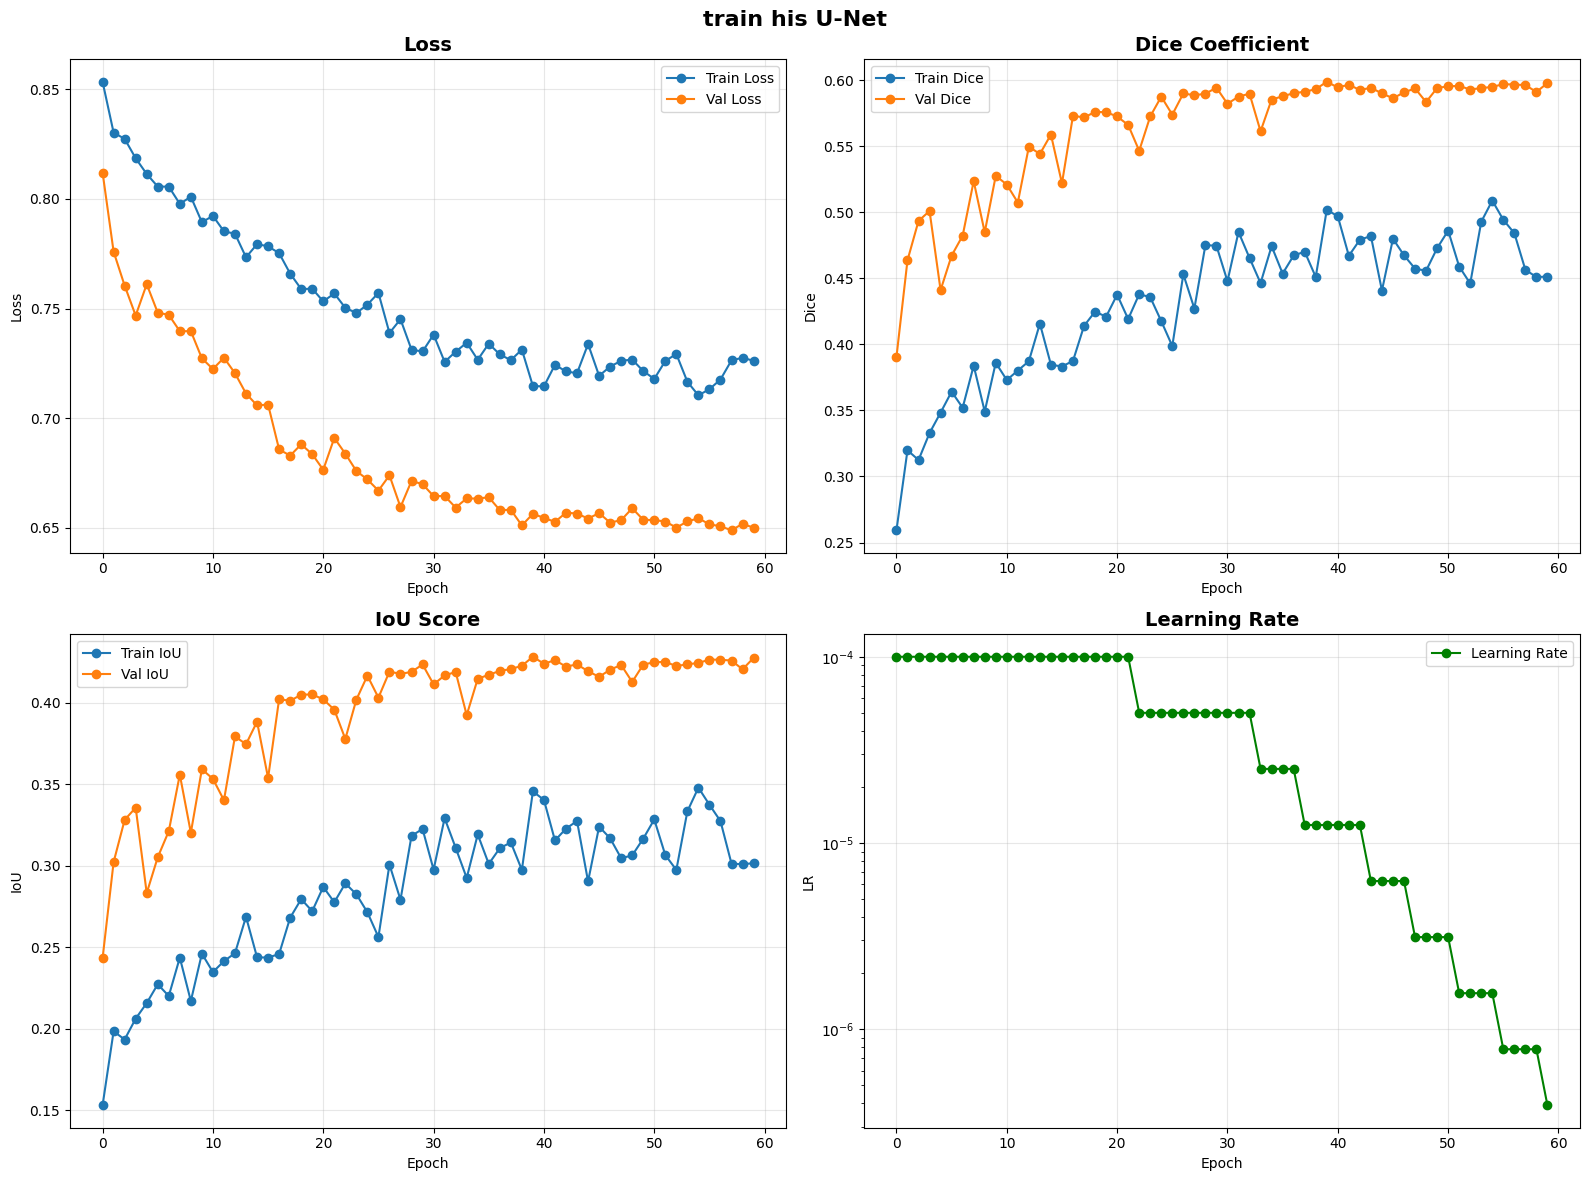

Train Loss:  [0.8534980326890945, 0.8302802860736846, 0.8274483144283294, 0.8185830026865005, 0.8114006847143174, 0.8056595116853714, 0.8056369751691819, 0.7977670341730118, 0.8010278046131134, 0.7893982946872711, 0.7922851711511611, 0.7852268010377884, 0.7841431587934494, 0.7733906477689743, 0.7793789714574814, 0.7784025579690933, 0.7752608060836792, 0.7659465283155441, 0.7588884651660919, 0.7590507864952087, 0.753268051147461, 0.7568751484155655, 0.7503169625997543, 0.7479441553354264, 0.751778843998909, 0.7571308881044387, 0.7388337463140487, 0.7451177060604095, 0.7312129676342011, 0.7303912043571472, 0.7380900681018829, 0.7256509929895401, 0.7302992403507232, 0.7343911528587341, 0.7266080945730209, 0.733966064453125, 0.7290601968765259, 0.7264398843050003, 0.7312657237052917, 0.7146115928888321, 0.7144774585962296, 0.7242988169193267, 0.7212941616773605, 0.7204835921525955, 0.7337896406650544, 0.7193004190921783, 0.72352594435215, 0.7261348396539689, 0.7267075121402741, 0.721475020

In [34]:
plot_training_history(history)

In [35]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    model.to(device)
    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if min(num_samples, len(images)) == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('in image', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('mask', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('prediction', fontsize=12)
        axes[i, 2].axis('off')

        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('overlap', fontsize=12)
        axes[i, 3].axis('off')

        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1])
        iou = iou_score(predictions[i:i+1], masks[i:i+1])


        axes[i, 3].text(
            0.5, -0.15,
            f'Dice: {dice:.4f}   |   IoU: {iou:.4f}',
            transform=axes[i, 3].transAxes,
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="none")
        )

    plt.suptitle('model predict U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

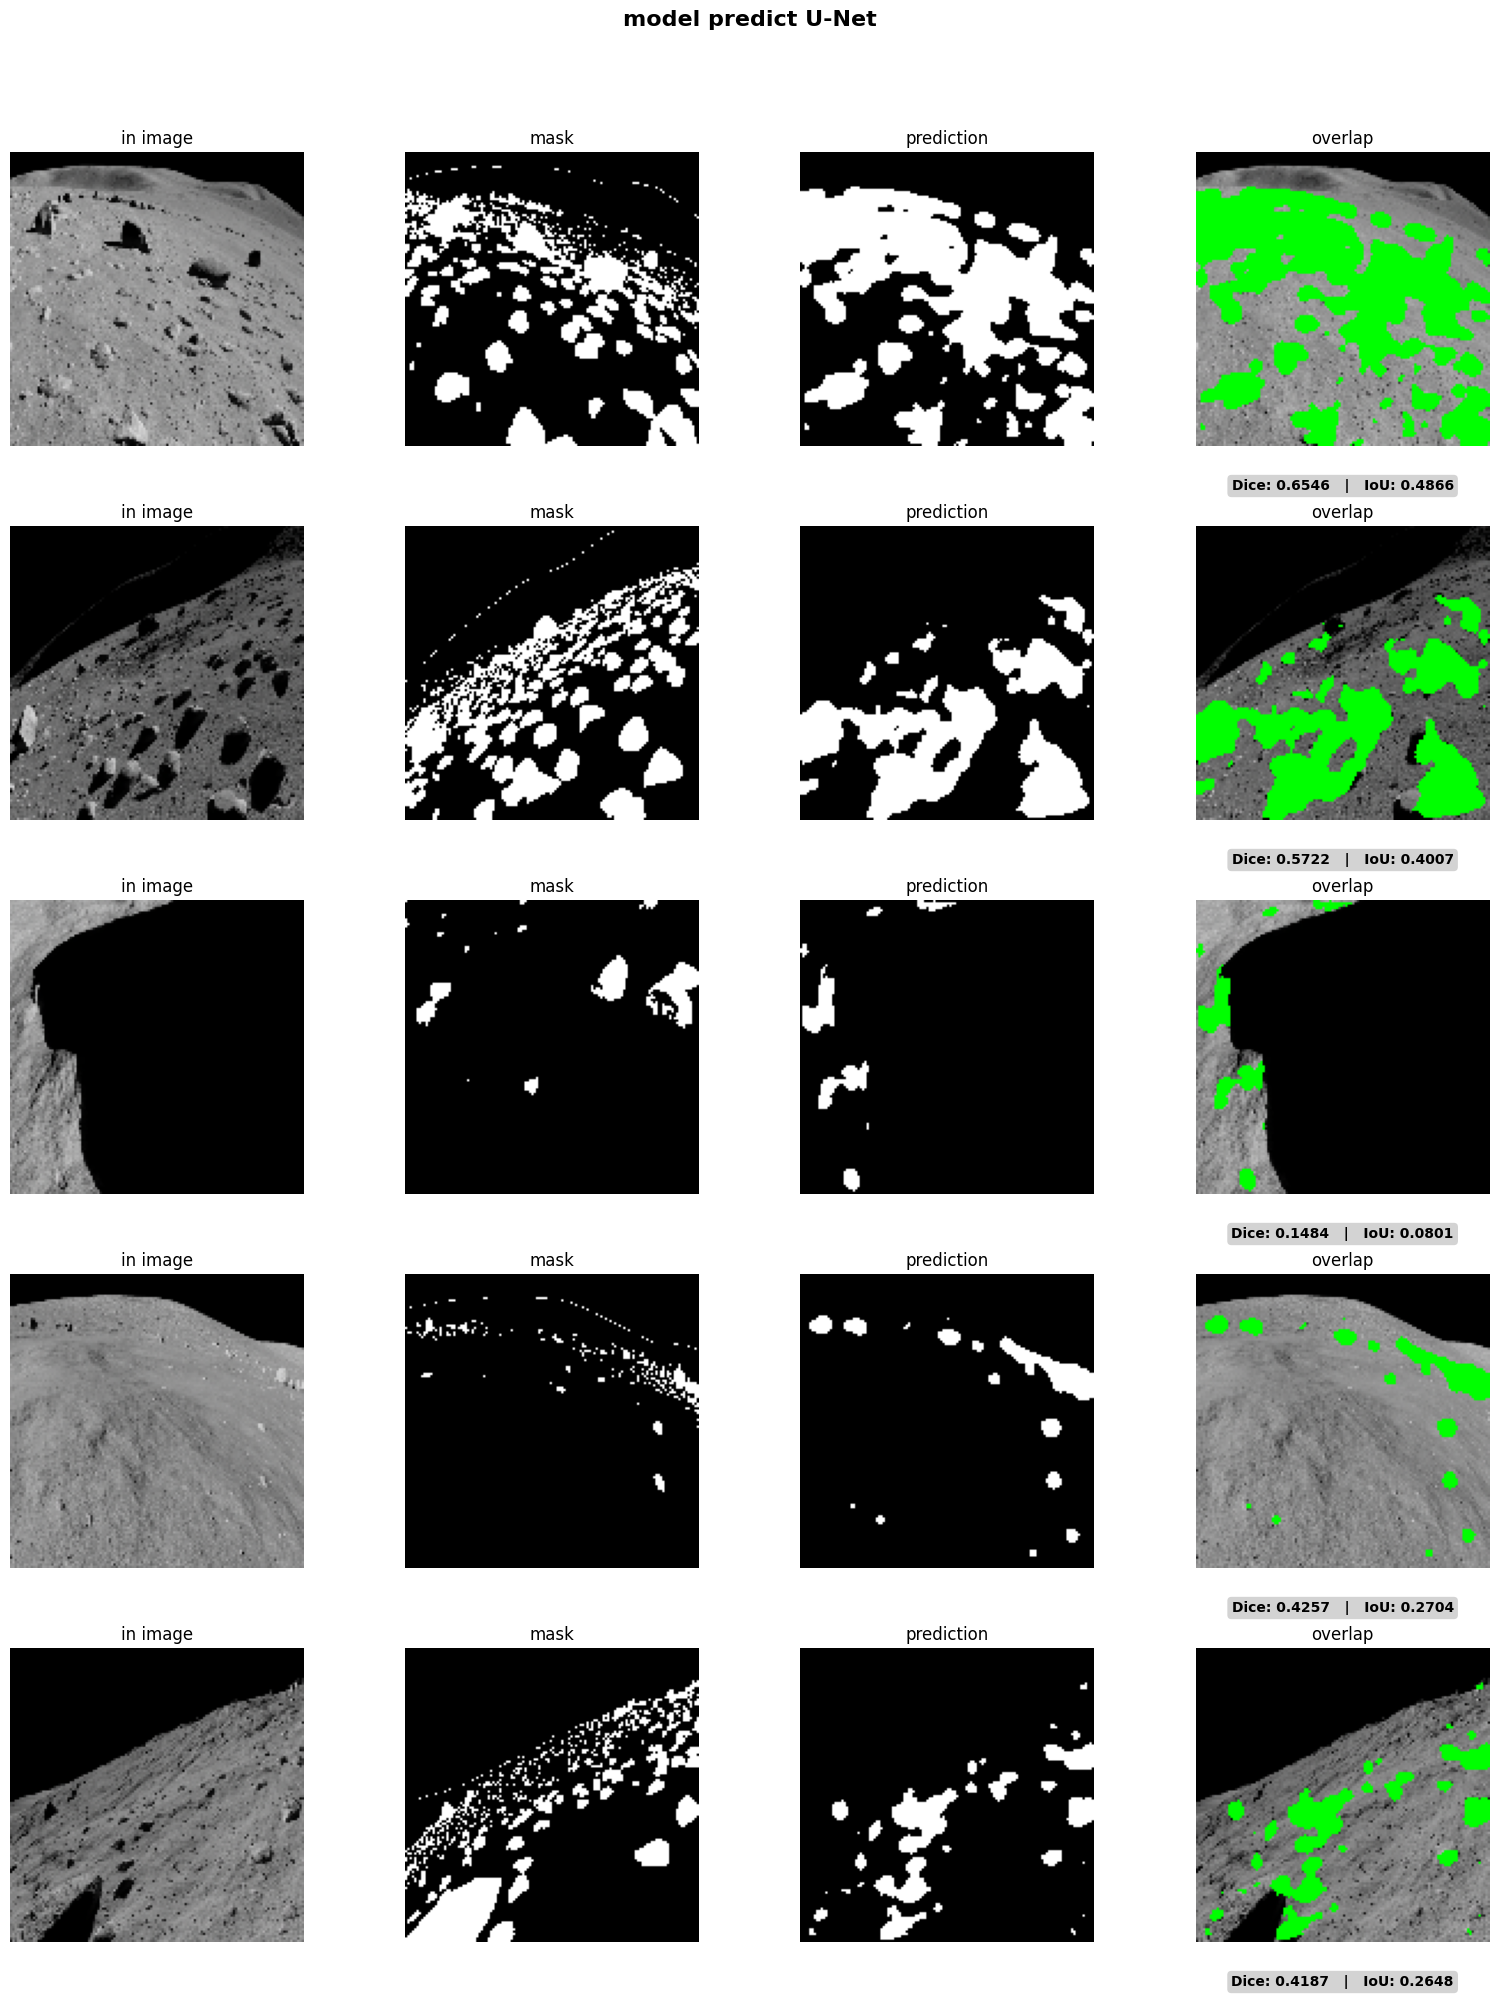

In [36]:
visualize_predictions(unet_model, val_loader, device, num_samples=5)

## Часть 3. U-Net с бэкбоном из классификатора

### Модель

In [37]:
class ResNetUNet(nn.Module):

    def __init__(self, out_channels=1, features=[32, 64, 128, 256], state_dict=None):
        super(ResNetUNet, self).__init__()

        resnet = ModelResnet()
        resnet.load_state_dict(state_dict)

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_blocks.append(resnet.basic_block_1_0) #32 канала
        self.encoder_blocks.append(resnet.basic_block_2_0) #64 каналов
        self.encoder_blocks.append(resnet.basic_block_3_0) #128 каналов
        self.encoder_blocks.append(resnet.basic_block_4_0) #256 каналов

        self.bottleneck = LayerConv(features[-1], features[-1] * 2)

        in_channels_up = features[-1] * 2
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(in_channels_up, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                LayerConv(feature * 2, feature)
            )
            in_channels_up = feature


        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid())

        total_params = sum(p.numel() for p in self.parameters())
        print("Params: ", total_params)
        print("encoder levels: ", len(features))
        print("channel conf: ", features)

    def forward(self, x):
        skip_connections = []
        for i, encoder_block in enumerate(self.encoder_blocks):
            x = encoder_block(x)
            skip_connections.append(x)
            if i == 0:
             x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)
            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        return output

In [38]:
resnet_unet = ResNetUNet(out_channels=1, state_dict=torch.load("model_resnet.pth"))
for param in resnet_unet.encoder_blocks.parameters():
  param.requires_grad = False

test_input = torch.randn(1, 3, 128, 128)
test_output = resnet_unet(test_input)

print("   IN:  ", test_input.shape)
print("   OUT: ", test_output.shape)

total_params = sum(p.numel() for p in resnet_unet.parameters())
trainable_params = sum(p.numel() for p in resnet_unet.parameters() if p.requires_grad)

print("   Total params: ", total_params)
print("   train params: ", trainable_params)

Params:  4663457
encoder levels:  4
channel conf:  [32, 64, 128, 256]
   IN:   torch.Size([1, 3, 128, 128])
   OUT:  torch.Size([1, 1, 128, 128])
   Total params:  4663457
   train params:  3446177


### Обучение

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("  Using dev: ", device)
resnet_unetA = ResNetUNet(out_channels=1, state_dict=torch.load("model_resnet.pth"))
for param in resnet_unetA.encoder_blocks.parameters():
  param.requires_grad = False

print("   train params: ", sum(p.numel() for p in resnet_unetA.parameters() if p.requires_grad))
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(resnet_unetA.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_resnet_unet_A = train_model(
    model=resnet_unetA,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_resnet_unet_A.pth'
)

  Using dev:  cuda
Params:  4663457
encoder levels:  4
channel conf:  [32, 64, 128, 256]
   train params:  3446177
Epoch  1 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s, loss=0.8074, dice=0.3513, iou=0.2131, acc=0.8256]



 Epoch res  1
  Train - Loss:  0.8381697922945023  Dice:  0.27055450081825255  IoU:  0.15872724875807762
  Val   - Loss:  0.8031546235084533  Dice:  0.3909323990345001  IoU:  0.24343937635421753  Acc:  0.8029571533203125
  LR:  0.0001
  Saved best model! Dice:  0.3909323990345001
Epoch  2 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.96it/s, loss=0.7551, dice=0.4235, iou=0.2686, acc=0.7747]



 Epoch res  2
  Train - Loss:  0.8204464614391327  Dice:  0.3034953556954861  IoU:  0.18313670121133327
  Val   - Loss:  0.7572014927864075  Dice:  0.4409907877445221  IoU:  0.28335864543914796  Acc:  0.73411865234375
  LR:  0.0001
  Saved best model! Dice:  0.4409907877445221
Epoch  3 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s, loss=0.7416, dice=0.4142, iou=0.2612, acc=0.8080]



 Epoch res  3
  Train - Loss:  0.8019198685884475  Dice:  0.33772983849048616  IoU:  0.20823654159903526
  Val   - Loss:  0.7320641994476318  Dice:  0.4759750247001648  IoU:  0.31354978680610657  Acc:  0.8088714599609375
  LR:  0.0001
  Saved best model! Dice:  0.4759750247001648
Epoch  4 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s, loss=0.7310, dice=0.4441, iou=0.2854, acc=0.8306]



 Epoch res  4
  Train - Loss:  0.7879460960626602  Dice:  0.3707751601934433  IoU:  0.2313241582363844
  Val   - Loss:  0.72086101770401  Dice:  0.5053272545337677  IoU:  0.33933846950531005  Acc:  0.838885498046875
  LR:  0.0001
  Saved best model! Dice:  0.5053272545337677
Epoch  5 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.97it/s, loss=0.7241, dice=0.4529, iou=0.2928, acc=0.8337]



 Epoch res  5
  Train - Loss:  0.7838292747735978  Dice:  0.3677725102752447  IoU:  0.23086711447685956
  Val   - Loss:  0.7166773080825806  Dice:  0.5065581858158111  IoU:  0.3408363997936249  Acc:  0.8336395263671875
  LR:  0.0001
  Saved best model! Dice:  0.5065581858158111
Epoch  6 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s, loss=0.7179, dice=0.4612, iou=0.2997, acc=0.8217]



 Epoch res  6
  Train - Loss:  0.7780040264129638  Dice:  0.3818558193743229  IoU:  0.2402332227677107
  Val   - Loss:  0.710427975654602  Dice:  0.5045778632164002  IoU:  0.33862144947052003  Acc:  0.814263916015625
  LR:  0.0001
Epoch  7 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.65it/s, loss=0.7111, dice=0.4632, iou=0.3014, acc=0.8463]



 Epoch res  7
  Train - Loss:  0.7751058369874955  Dice:  0.38326812982559205  IoU:  0.2436930261552334
  Val   - Loss:  0.7037214040756226  Dice:  0.5054223120212555  IoU:  0.3404086410999298  Acc:  0.8487335205078125
  LR:  0.0001
Epoch  8 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s, loss=0.7095, dice=0.4815, iou=0.3171, acc=0.8492]



 Epoch res  8
  Train - Loss:  0.7699549287557602  Dice:  0.3903819158673286  IoU:  0.24778973087668418
  Val   - Loss:  0.6983853459358216  Dice:  0.5271288514137268  IoU:  0.35903298258781435  Acc:  0.83624267578125
  LR:  0.0001
  Saved best model! Dice:  0.5271288514137268
Epoch  9 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.17it/s, loss=0.7061, dice=0.4915, iou=0.3259, acc=0.8547]



 Epoch res  9
  Train - Loss:  0.7599797189235687  Dice:  0.4133010596036911  IoU:  0.264139049500227
  Val   - Loss:  0.6968379020690918  Dice:  0.5325762748718261  IoU:  0.36386372447013854  Acc:  0.8468017578125
  LR:  0.0001
  Saved best model! Dice:  0.5325762748718261
Epoch  10 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s, loss=0.7010, dice=0.4918, iou=0.3261, acc=0.8450]



 Epoch res  10
  Train - Loss:  0.7640032500028611  Dice:  0.3960137665271759  IoU:  0.25104719027876854
  Val   - Loss:  0.6933189272880554  Dice:  0.5250383138656616  IoU:  0.3571557760238647  Acc:  0.83310546875
  LR:  0.0001
Epoch  11 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.23it/s, loss=0.6909, dice=0.5009, iou=0.3342, acc=0.8528]



 Epoch res  11
  Train - Loss:  0.7656468003988266  Dice:  0.381729494035244  IoU:  0.24171304032206536
  Val   - Loss:  0.6832539439201355  Dice:  0.5334385633468628  IoU:  0.3648369610309601  Acc:  0.8388519287109375
  LR:  0.0001
  Saved best model! Dice:  0.5334385633468628
Epoch  12 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.43it/s, loss=0.6937, dice=0.5190, iou=0.3505, acc=0.8480]



 Epoch res  12
  Train - Loss:  0.7516543954610825  Dice:  0.4190868251025677  IoU:  0.2725618999451399
  Val   - Loss:  0.6895698428153991  Dice:  0.5401000499725341  IoU:  0.37118071913719175  Acc:  0.836358642578125
  LR:  0.0001
  Saved best model! Dice:  0.5401000499725341
Epoch  13 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.04it/s, loss=0.6909, dice=0.5105, iou=0.3427, acc=0.8569]



 Epoch res  13
  Train - Loss:  0.7489420980215072  Dice:  0.43597845956683157  IoU:  0.2856613799929619
  Val   - Loss:  0.6827794671058655  Dice:  0.5446501791477203  IoU:  0.37544233798980714  Acc:  0.8523406982421875
  LR:  0.0001
  Saved best model! Dice:  0.5446501791477203
Epoch  14 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.11it/s, loss=0.6902, dice=0.4929, iou=0.3270, acc=0.8459]



 Epoch res  14
  Train - Loss:  0.7563374221324921  Dice:  0.3982305429875851  IoU:  0.25391803309321404
  Val   - Loss:  0.6800325036048889  Dice:  0.5320485413074494  IoU:  0.36414716243743894  Acc:  0.8341339111328125
  LR:  0.0001
Epoch  15 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s, loss=0.6834, dice=0.5260, iou=0.3569, acc=0.8489]



 Epoch res  15
  Train - Loss:  0.7495984703302383  Dice:  0.4124730810523033  IoU:  0.2650163695216179
  Val   - Loss:  0.6779912710189819  Dice:  0.5446478605270386  IoU:  0.37546842694282534  Acc:  0.8374359130859375
  LR:  0.0001
Epoch  16 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.7063, dice=0.4671, iou=0.3047, acc=0.8229]



 Epoch res  16
  Train - Loss:  0.7447157174348831  Dice:  0.42275345250964164  IoU:  0.27282289788126945
  Val   - Loss:  0.6860204696655273  Dice:  0.5208420336246491  IoU:  0.3544346451759338  Acc:  0.83138427734375
  LR:  0.0001
Epoch  17 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.86it/s, loss=0.6832, dice=0.4954, iou=0.3292, acc=0.8499]



 Epoch res  17
  Train - Loss:  0.7436358332633972  Dice:  0.41668017879128455  IoU:  0.26993518732488153
  Val   - Loss:  0.670036232471466  Dice:  0.5431566834449768  IoU:  0.374052619934082  Acc:  0.8413238525390625
  LR:  5e-05
Epoch  18 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s, loss=0.6929, dice=0.4771, iou=0.3133, acc=0.8397]



 Epoch res  18
  Train - Loss:  0.7323960095643998  Dice:  0.44398236721754075  IoU:  0.28976698480546476
  Val   - Loss:  0.6721426725387574  Dice:  0.5467800259590149  IoU:  0.3782490432262421  Acc:  0.84398193359375
  LR:  5e-05
  Saved best model! Dice:  0.5467800259590149
Epoch  19 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s, loss=0.6925, dice=0.4857, iou=0.3207, acc=0.8386]



 Epoch res  19
  Train - Loss:  0.7356512725353241  Dice:  0.43645976185798646  IoU:  0.2877560775727034
  Val   - Loss:  0.6726797938346862  Dice:  0.5508338809013367  IoU:  0.3819544196128845  Acc:  0.8428924560546875
  LR:  5e-05
  Saved best model! Dice:  0.5508338809013367
Epoch  20 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.45it/s, loss=0.6853, dice=0.5089, iou=0.3413, acc=0.8514]



 Epoch res  20
  Train - Loss:  0.7291041433811187  Dice:  0.4552988186478615  IoU:  0.3026192903518677
  Val   - Loss:  0.6707430124282837  Dice:  0.5568881511688233  IoU:  0.38707857131958007  Acc:  0.8462860107421875
  LR:  5e-05
  Saved best model! Dice:  0.5568881511688233
Epoch  21 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.79it/s, loss=0.6884, dice=0.5073, iou=0.3399, acc=0.8486]



 Epoch res  21
  Train - Loss:  0.7254728227853775  Dice:  0.459650881588459  IoU:  0.3051322244107723
  Val   - Loss:  0.6741084933280945  Dice:  0.5561519503593445  IoU:  0.3864315927028656  Acc:  0.846282958984375
  LR:  5e-05
Epoch  22 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s, loss=0.6808, dice=0.5095, iou=0.3418, acc=0.8412]



 Epoch res  22
  Train - Loss:  0.7319156199693679  Dice:  0.4349481001496315  IoU:  0.28523523584008215
  Val   - Loss:  0.6696117877960205  Dice:  0.5445906817913055  IoU:  0.37558017373085023  Acc:  0.835406494140625
  LR:  5e-05
Epoch  23 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.03it/s, loss=0.6781, dice=0.5173, iou=0.3489, acc=0.8484]



 Epoch res  23
  Train - Loss:  0.7264345109462738  Dice:  0.4515039578080177  IoU:  0.3000677913427353
  Val   - Loss:  0.6696230411529541  Dice:  0.5446154713630676  IoU:  0.37579589486122134  Acc:  0.8371246337890625
  LR:  5e-05
Epoch  24 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s, loss=0.6794, dice=0.5139, iou=0.3458, acc=0.8474]



 Epoch res  24
  Train - Loss:  0.725023838877678  Dice:  0.45633765012025834  IoU:  0.3019843868911266
  Val   - Loss:  0.6681017994880676  Dice:  0.546422815322876  IoU:  0.37802823781967165  Acc:  0.8478607177734375
  LR:  2.5e-05
Epoch  25 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.33it/s, loss=0.6779, dice=0.4980, iou=0.3315, acc=0.8529]



 Epoch res  25
  Train - Loss:  0.7239967525005341  Dice:  0.45235286802053454  IoU:  0.3016792733222246
  Val   - Loss:  0.6646117091178894  Dice:  0.5433149099349975  IoU:  0.3749091625213623  Acc:  0.8512237548828125
  LR:  2.5e-05
Epoch  26 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s, loss=0.6732, dice=0.5126, iou=0.3446, acc=0.8550]



 Epoch res  26
  Train - Loss:  0.7273957312107087  Dice:  0.4507809430360794  IoU:  0.2948979020118713
  Val   - Loss:  0.6631901621818542  Dice:  0.5450433790683746  IoU:  0.3765126347541809  Acc:  0.8440093994140625
  LR:  2.5e-05
Epoch  27 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s, loss=0.6782, dice=0.5075, iou=0.3401, acc=0.8482]



 Epoch res  27
  Train - Loss:  0.7357012987136841  Dice:  0.4170389920473099  IoU:  0.2703370228409767
  Val   - Loss:  0.6661039590835571  Dice:  0.547171026468277  IoU:  0.378482973575592  Acc:  0.8420806884765625
  LR:  2.5e-05
Epoch  28 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s, loss=0.6756, dice=0.5209, iou=0.3522, acc=0.8422]



 Epoch res  28
  Train - Loss:  0.7273473650217056  Dice:  0.43737487867474556  IoU:  0.2875510290265083
  Val   - Loss:  0.6662846088409424  Dice:  0.5459894955158233  IoU:  0.3774278163909912  Acc:  0.8377716064453125
  LR:  1.25e-05
Epoch  29 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.72it/s, loss=0.6770, dice=0.5071, iou=0.3397, acc=0.8547]



 Epoch res  29
  Train - Loss:  0.7212625056505203  Dice:  0.45605309009552003  IoU:  0.3047299277037382
  Val   - Loss:  0.6631009221076966  Dice:  0.5485081017017365  IoU:  0.3802494525909424  Acc:  0.855670166015625
  LR:  1.25e-05
Epoch  30 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.12it/s, loss=0.6789, dice=0.5047, iou=0.3375, acc=0.8484]



 Epoch res  30
  Train - Loss:  0.7162695556879044  Dice:  0.4735303848981857  IoU:  0.31539693027734755
  Val   - Loss:  0.6639100193977356  Dice:  0.5502755641937256  IoU:  0.38164467811584474  Acc:  0.84810791015625
  LR:  1.25e-05
Epoch  31 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, loss=0.6795, dice=0.5102, iou=0.3425, acc=0.8484]



 Epoch res  31
  Train - Loss:  0.7188747435808182  Dice:  0.4632775463163853  IoU:  0.3107163369655609
  Val   - Loss:  0.6651178121566772  Dice:  0.549821799993515  IoU:  0.3814945161342621  Acc:  0.850006103515625
  LR:  1.25e-05
Epoch  32 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s, loss=0.6779, dice=0.5120, iou=0.3441, acc=0.8507]



 Epoch res  32
  Train - Loss:  0.7187231004238128  Dice:  0.4641923815011978  IoU:  0.30894975066185
  Val   - Loss:  0.6644197106361389  Dice:  0.553435093164444  IoU:  0.38455620408058167  Acc:  0.851068115234375
  LR:  6.25e-06
Epoch  33 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.82it/s, loss=0.6753, dice=0.5114, iou=0.3436, acc=0.8538]



 Epoch res  33
  Train - Loss:  0.7245972633361817  Dice:  0.4429373100399971  IoU:  0.2923781298100948
  Val   - Loss:  0.6624174952507019  Dice:  0.5494651854038238  IoU:  0.3811931014060974  Acc:  0.85325927734375
  LR:  6.25e-06
Epoch  34 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.6699, dice=0.5226, iou=0.3537, acc=0.8569]



 Epoch res  34
  Train - Loss:  0.732536894083023  Dice:  0.42715561017394066  IoU:  0.27690792344510556
  Val   - Loss:  0.6594503998756409  Dice:  0.5525877118110657  IoU:  0.383728963136673  Acc:  0.8504852294921875
  LR:  6.25e-06
Epoch  35 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s, loss=0.6783, dice=0.5058, iou=0.3385, acc=0.8500]



 Epoch res  35
  Train - Loss:  0.712397912144661  Dice:  0.4763181135058403  IoU:  0.31861414909362795
  Val   - Loss:  0.663532292842865  Dice:  0.5537302851676941  IoU:  0.38485307097434995  Acc:  0.848919677734375
  LR:  6.25e-06
Epoch  36 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.06it/s, loss=0.6764, dice=0.5113, iou=0.3435, acc=0.8488]



 Epoch res  36
  Train - Loss:  0.7153292030096055  Dice:  0.4744941875338554  IoU:  0.32038743421435356
  Val   - Loss:  0.6634387373924255  Dice:  0.5513429582118988  IoU:  0.38274388909339907  Acc:  0.8467041015625
  LR:  3.125e-06
Epoch  37 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.12it/s, loss=0.6758, dice=0.5131, iou=0.3451, acc=0.8512]



 Epoch res  37
  Train - Loss:  0.7212974399328231  Dice:  0.45379375740885736  IoU:  0.29982629641890524
  Val   - Loss:  0.6628237009048462  Dice:  0.550017261505127  IoU:  0.38162933588027953  Acc:  0.84820556640625
  LR:  3.125e-06
Epoch  38 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.19it/s, loss=0.6658, dice=0.5332, iou=0.3635, acc=0.8616]



 Epoch res  38
  Train - Loss:  0.7366491287946701  Dice:  0.4092749930918217  IoU:  0.2634675487875938
  Val   - Loss:  0.6591120719909668  Dice:  0.5478146016597748  IoU:  0.3796064376831055  Acc:  0.8521209716796875
  LR:  3.125e-06
Epoch  39 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s, loss=0.6729, dice=0.5253, iou=0.3562, acc=0.8596]



 Epoch res  39
  Train - Loss:  0.7193256914615631  Dice:  0.45775609239935877  IoU:  0.3048046514391899
  Val   - Loss:  0.6631624817848205  Dice:  0.5572375357151031  IoU:  0.3880587875843048  Acc:  0.8532928466796875
  LR:  3.125e-06
  Saved best model! Dice:  0.5572375357151031
Epoch  40 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s, loss=0.6711, dice=0.5293, iou=0.3599, acc=0.8583]



 Epoch res  40
  Train - Loss:  0.7213672399520874  Dice:  0.45469882190227506  IoU:  0.3014456693083048
  Val   - Loss:  0.6619084715843201  Dice:  0.5548213183879852  IoU:  0.38566508889198303  Acc:  0.8483123779296875
  LR:  3.125e-06
Epoch  41 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s, loss=0.6742, dice=0.5199, iou=0.3512, acc=0.8578]



 Epoch res  41
  Train - Loss:  0.7252036541700363  Dice:  0.4399796351790428  IoU:  0.290059357881546
  Val   - Loss:  0.6629041314125061  Dice:  0.5568282783031464  IoU:  0.3875856637954712  Acc:  0.8517333984375
  LR:  3.125e-06
Epoch  42 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s, loss=0.6715, dice=0.5266, iou=0.3574, acc=0.8596]



 Epoch res  42
  Train - Loss:  0.7244369685649872  Dice:  0.44787160903215406  IoU:  0.29565275758504866
  Val   - Loss:  0.661585021018982  Dice:  0.5583383142948151  IoU:  0.3890779256820679  Acc:  0.8558135986328125
  LR:  3.125e-06
  Saved best model! Dice:  0.5583383142948151
Epoch  43 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.42it/s, loss=0.6706, dice=0.5254, iou=0.3563, acc=0.8534]



 Epoch res  43
  Train - Loss:  0.7193313211202621  Dice:  0.457856024056673  IoU:  0.3027431298047304
  Val   - Loss:  0.6610695123672485  Dice:  0.554878044128418  IoU:  0.38562055826187136  Acc:  0.84608154296875
  LR:  3.125e-06
Epoch  44 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s, loss=0.6726, dice=0.5153, iou=0.3470, acc=0.8551]



 Epoch res  44
  Train - Loss:  0.7245283871889114  Dice:  0.4462136223912239  IoU:  0.2947354927659035
  Val   - Loss:  0.6599661588668824  Dice:  0.5531965315341949  IoU:  0.38421552777290346  Acc:  0.84976806640625
  LR:  3.125e-06
Epoch  45 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s, loss=0.6717, dice=0.5232, iou=0.3543, acc=0.8520]



 Epoch res  45
  Train - Loss:  0.7142005860805511  Dice:  0.4763614282011986  IoU:  0.320307032763958
  Val   - Loss:  0.6608895301818848  Dice:  0.5555615425109863  IoU:  0.3862986028194427  Acc:  0.8450714111328125
  LR:  3.125e-06
Epoch  46 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s, loss=0.6714, dice=0.5164, iou=0.3481, acc=0.8550]



 Epoch res  46
  Train - Loss:  0.7246339499950409  Dice:  0.44511090964078903  IoU:  0.2905445143580437
  Val   - Loss:  0.6594483733177186  Dice:  0.552021998167038  IoU:  0.3834675431251526  Acc:  0.8521240234375
  LR:  1.5625e-06
Epoch  47 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.49it/s, loss=0.6703, dice=0.5202, iou=0.3516, acc=0.8605]



 Epoch res  47
  Train - Loss:  0.7136929392814636  Dice:  0.47855512127280236  IoU:  0.32097795605659485
  Val   - Loss:  0.6600889801979065  Dice:  0.5516488969326019  IoU:  0.3831893265247345  Acc:  0.8575164794921875
  LR:  1.5625e-06
Epoch  48 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s, loss=0.6710, dice=0.5248, iou=0.3557, acc=0.8546]



 Epoch res  48
  Train - Loss:  0.7224008560180664  Dice:  0.4469486825168133  IoU:  0.29424684345722196
  Val   - Loss:  0.660735023021698  Dice:  0.5547110974788666  IoU:  0.3857176065444946  Acc:  0.846405029296875
  LR:  1.5625e-06
Epoch  49 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.99it/s, loss=0.6727, dice=0.5170, iou=0.3486, acc=0.8592]



 Epoch res  49
  Train - Loss:  0.7172175377607346  Dice:  0.47251206561923026  IoU:  0.3150986596941948
  Val   - Loss:  0.6603796124458313  Dice:  0.5543120801448822  IoU:  0.38523282408714293  Acc:  0.856768798828125
  LR:  1.5625e-06
Epoch  50 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.49it/s, loss=0.6727, dice=0.5158, iou=0.3475, acc=0.8547]



 Epoch res  50
  Train - Loss:  0.7257824063301086  Dice:  0.4410478822886944  IoU:  0.2910264849662781
  Val   - Loss:  0.6606543064117432  Dice:  0.5512375771999359  IoU:  0.3826623797416687  Acc:  0.8518402099609375
  LR:  7.8125e-07
Epoch  51 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s, loss=0.6766, dice=0.5093, iou=0.3417, acc=0.8539]



 Epoch res  51
  Train - Loss:  0.7136092782020569  Dice:  0.4718975625932217  IoU:  0.3164782337844372
  Val   - Loss:  0.6628447532653808  Dice:  0.5544752717018128  IoU:  0.3856783449649811  Acc:  0.8525390625
  LR:  7.8125e-07
Epoch  52 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.6742, dice=0.5171, iou=0.3487, acc=0.8494]



 Epoch res  52
  Train - Loss:  0.7197855770587921  Dice:  0.4540631830692291  IoU:  0.29971914142370226
  Val   - Loss:  0.6623795747756958  Dice:  0.5525988519191742  IoU:  0.3839120209217072  Acc:  0.84622802734375
  LR:  7.8125e-07
Epoch  53 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.45it/s, loss=0.6739, dice=0.5185, iou=0.3500, acc=0.8497]



 Epoch res  53
  Train - Loss:  0.7139708876609803  Dice:  0.4731119334697723  IoU:  0.3170318819582462
  Val   - Loss:  0.663331949710846  Dice:  0.5545825362205505  IoU:  0.38541884422302247  Acc:  0.84439697265625
  LR:  7.8125e-07
Epoch  54 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s, loss=0.6709, dice=0.5252, iou=0.3561, acc=0.8577]



 Epoch res  54
  Train - Loss:  0.724212896823883  Dice:  0.4461089953780174  IoU:  0.29457255378365516
  Val   - Loss:  0.6613536477088928  Dice:  0.5530294954776764  IoU:  0.38422649502754214  Acc:  0.8511627197265625
  LR:  3.90625e-07
Epoch  55 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s, loss=0.6692, dice=0.5297, iou=0.3602, acc=0.8564]



 Epoch res  55
  Train - Loss:  0.7267052948474884  Dice:  0.43955953810364007  IoU:  0.2915422740392387
  Val   - Loss:  0.6601752996444702  Dice:  0.5537981510162353  IoU:  0.38474937081336974  Acc:  0.84908447265625
  LR:  3.90625e-07
Epoch  56 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.63it/s, loss=0.6727, dice=0.5197, iou=0.3511, acc=0.8481]



 Epoch res  56
  Train - Loss:  0.7194470643997193  Dice:  0.4562371507287025  IoU:  0.29989339262247083
  Val   - Loss:  0.6623727798461914  Dice:  0.5509276747703552  IoU:  0.38199229836463927  Acc:  0.8395843505859375
  LR:  3.90625e-07
Epoch  57 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.31it/s, loss=0.6759, dice=0.5163, iou=0.3480, acc=0.8490]



 Epoch res  57
  Train - Loss:  0.6977211326360703  Dice:  0.5175345703959465  IoU:  0.3538247846066952
  Val   - Loss:  0.6639620900154114  Dice:  0.5518287301063538  IoU:  0.3831793308258057  Acc:  0.845159912109375
  LR:  3.90625e-07
Epoch  58 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s, loss=0.6782, dice=0.5169, iou=0.3486, acc=0.8404]



 Epoch res  58
  Train - Loss:  0.7200071811676025  Dice:  0.4597658209502697  IoU:  0.305534665286541
  Val   - Loss:  0.6667909741401672  Dice:  0.5493852138519287  IoU:  0.380309921503067  Acc:  0.8323150634765625
  LR:  1.953125e-07
Epoch  59 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.6762, dice=0.5175, iou=0.3491, acc=0.8535]



 Epoch res  59
  Train - Loss:  0.7173951476812362  Dice:  0.46073759645223616  IoU:  0.30789697989821435
  Val   - Loss:  0.6635380983352661  Dice:  0.5545400559902192  IoU:  0.385722815990448  Acc:  0.8503875732421875
  LR:  1.953125e-07
Epoch  60 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s, loss=0.6721, dice=0.5222, iou=0.3534, acc=0.8530]


 Epoch res  60
  Train - Loss:  0.7202421635389328  Dice:  0.4582324832677841  IoU:  0.30493096113204954
  Val   - Loss:  0.662332022190094  Dice:  0.5492841839790344  IoU:  0.38091444969177246  Acc:  0.8474334716796875
  LR:  1.953125e-07
Best Val Dice:  0.5583383142948151


**Результы обучения U-Net с бэкбоном из ResNet с заморозкой:** на 46 эпохе модель достигла на валидации Dice = 0.5067, IoU = 0.3402, Pixel Acc = 0.8614

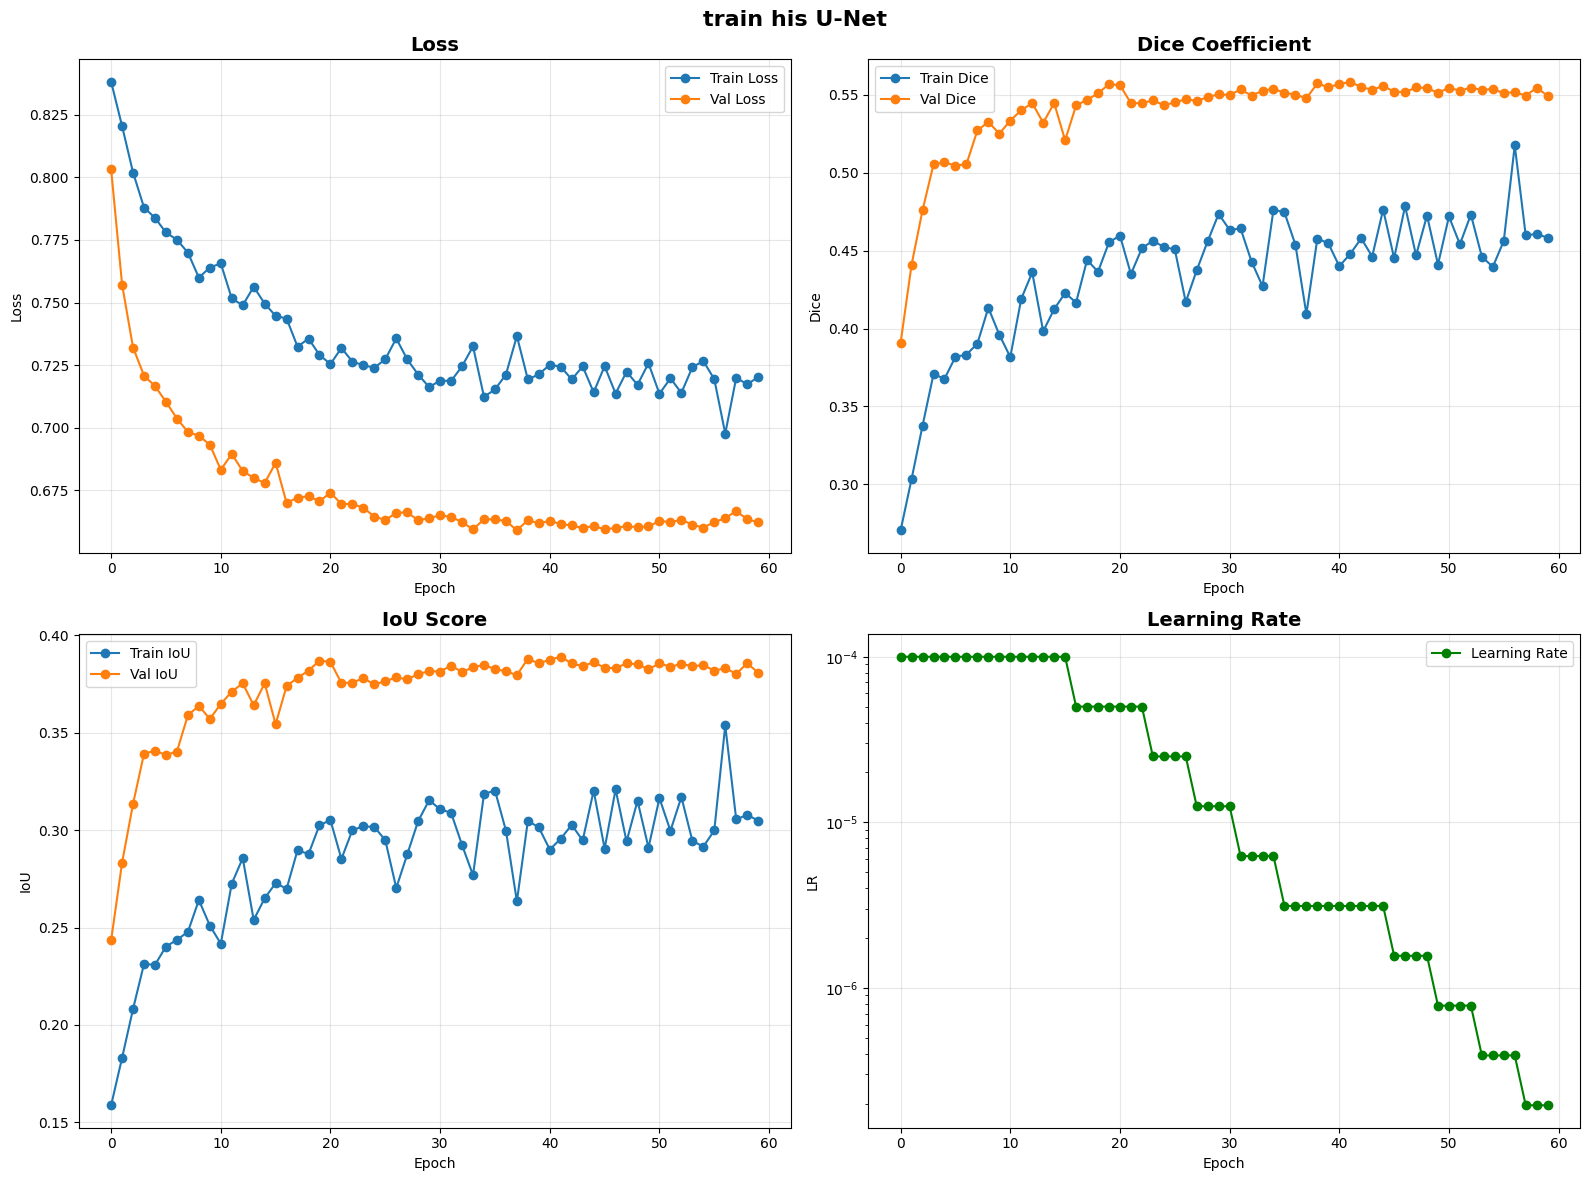

Train Loss:  [0.8381697922945023, 0.8204464614391327, 0.8019198685884475, 0.7879460960626602, 0.7838292747735978, 0.7780040264129638, 0.7751058369874955, 0.7699549287557602, 0.7599797189235687, 0.7640032500028611, 0.7656468003988266, 0.7516543954610825, 0.7489420980215072, 0.7563374221324921, 0.7495984703302383, 0.7447157174348831, 0.7436358332633972, 0.7323960095643998, 0.7356512725353241, 0.7291041433811187, 0.7254728227853775, 0.7319156199693679, 0.7264345109462738, 0.725023838877678, 0.7239967525005341, 0.7273957312107087, 0.7357012987136841, 0.7273473650217056, 0.7212625056505203, 0.7162695556879044, 0.7188747435808182, 0.7187231004238128, 0.7245972633361817, 0.732536894083023, 0.712397912144661, 0.7153292030096055, 0.7212974399328231, 0.7366491287946701, 0.7193256914615631, 0.7213672399520874, 0.7252036541700363, 0.7244369685649872, 0.7193313211202621, 0.7245283871889114, 0.7142005860805511, 0.7246339499950409, 0.7136929392814636, 0.7224008560180664, 0.7172175377607346, 0.7257824

In [40]:
plot_training_history(history_resnet_unet_A)

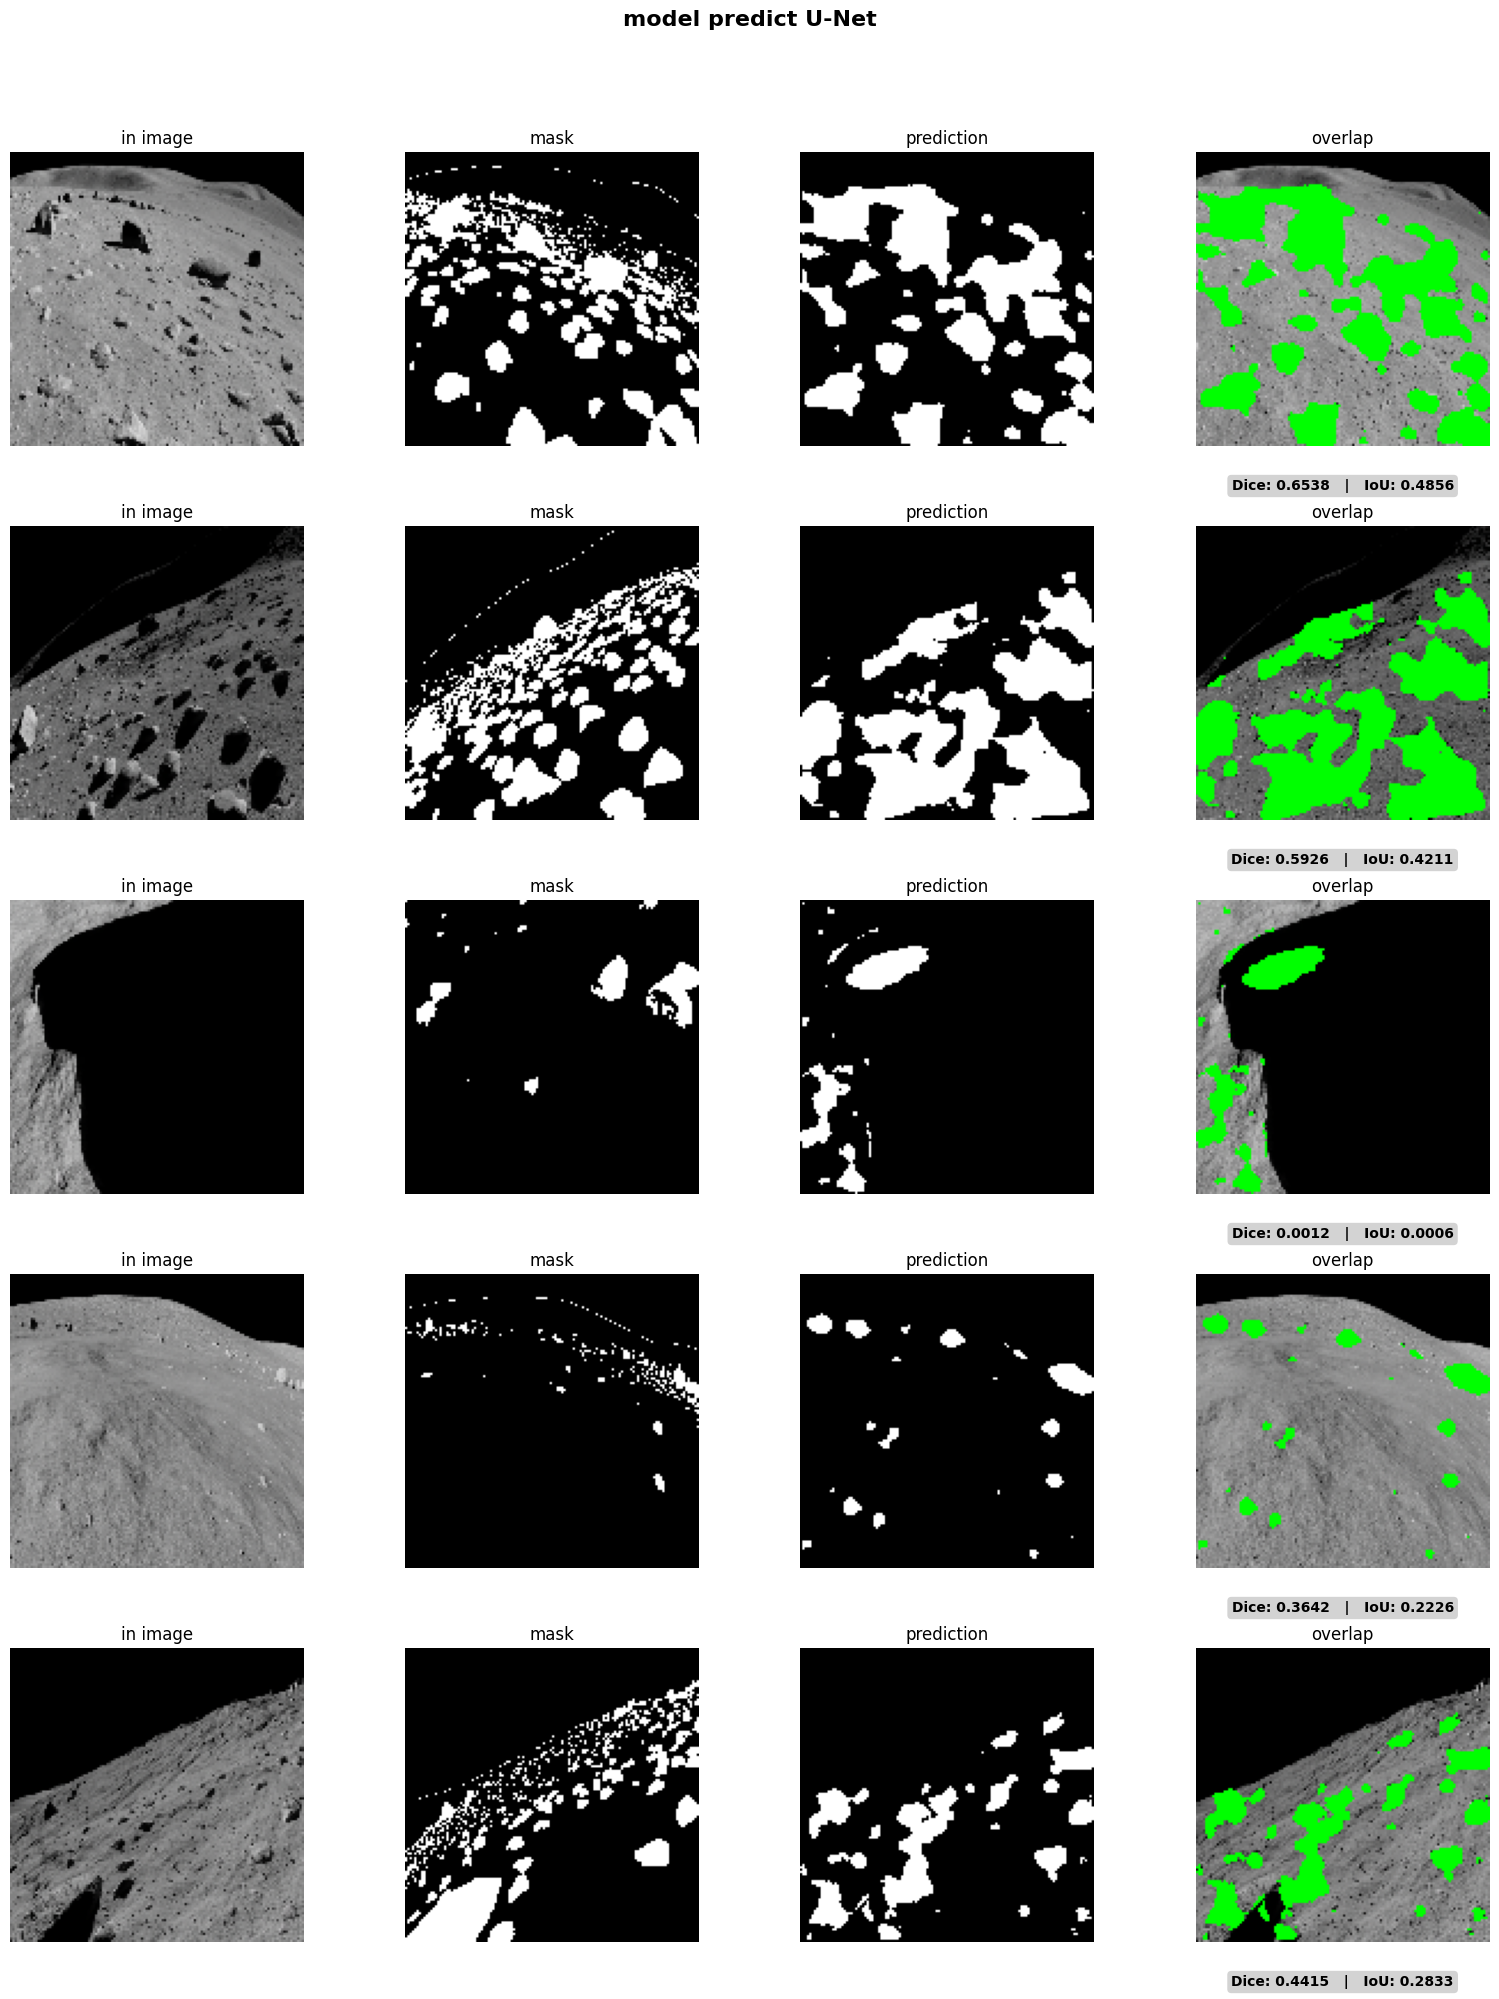

In [41]:
visualize_predictions(resnet_unetA, val_loader, device, num_samples=5)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("  using dev: ", device)
resnet_unetB = ResNetUNet(out_channels=1, state_dict=torch.load("model_resnet.pth", map_location=torch.device("cpu")))
for param in resnet_unetB.encoder_blocks.parameters():
  param.requires_grad = True
print("   train params: ", sum(p.numel() for p in resnet_unetB.parameters() if p.requires_grad))

criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
encoder_params = []
decoder_params = []
for name, param in resnet_unetB.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = torch.optim.Adam([{'params': encoder_params, 'lr': 1e-5}, {'params': decoder_params, 'lr': 1e-4}], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_resnet_unet_B = train_model(
    model=resnet_unetB,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_resnet_unet_B.pth'
)

  using dev:  cuda
Params:  4663457
encoder levels:  4
channel conf:  [32, 64, 128, 256]
   train params:  4663457
Epoch  1 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.37it/s, loss=0.8201, dice=0.3399, iou=0.2048, acc=0.6446]



 Epoch res  1
  Train - Loss:  0.8657196044921875  Dice:  0.24206921197474002  IoU:  0.14072239585220814
  Val   - Loss:  0.8159879922866822  Dice:  0.3522852838039398  IoU:  0.21418821513652803  Acc:  0.5427093505859375
  LR:  1e-05
  Saved best model! Dice:  0.3522852838039398
Epoch  2 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s, loss=0.7809, dice=0.4151, iou=0.2619, acc=0.7259]



 Epoch res  2
  Train - Loss:  0.8389551430940628  Dice:  0.3053288921713829  IoU:  0.18305685222148896
  Val   - Loss:  0.7842073917388916  Dice:  0.4047108829021454  IoU:  0.25405588150024416  Acc:  0.630999755859375
  LR:  1e-05
  Saved best model! Dice:  0.4047108829021454
Epoch  3 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s, loss=0.7645, dice=0.4607, iou=0.2993, acc=0.7910]



 Epoch res  3
  Train - Loss:  0.8294643819332123  Dice:  0.32416727058589456  IoU:  0.1999456077814102
  Val   - Loss:  0.7629364490509033  Dice:  0.4826339900493622  IoU:  0.31896395087242124  Acc:  0.7562164306640625
  LR:  1e-05
  Saved best model! Dice:  0.4826339900493622
Epoch  4 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s, loss=0.7544, dice=0.4810, iou=0.3166, acc=0.8274]



 Epoch res  4
  Train - Loss:  0.8227376997470855  Dice:  0.3391208354383707  IoU:  0.20793246440589427
  Val   - Loss:  0.750019085407257  Dice:  0.5175965070724488  IoU:  0.3498883366584778  Acc:  0.80986328125
  LR:  1e-05
  Saved best model! Dice:  0.5175965070724488
Epoch  5 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.04it/s, loss=0.7575, dice=0.4768, iou=0.3130, acc=0.8108]



 Epoch res  5
  Train - Loss:  0.8117083668708801  Dice:  0.3605258703231812  IoU:  0.22428265176713466
  Val   - Loss:  0.7489940166473389  Dice:  0.5132478833198547  IoU:  0.3461009502410889  Acc:  0.7979766845703125
  LR:  1e-05
Epoch  6 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s, loss=0.7454, dice=0.4916, iou=0.3259, acc=0.8181]



 Epoch res  6
  Train - Loss:  0.8053550332784652  Dice:  0.38849731124937537  IoU:  0.24644756149500607
  Val   - Loss:  0.7433364629745484  Dice:  0.5042189240455628  IoU:  0.3375601828098297  Acc:  0.78387451171875
  LR:  1e-05
Epoch  7 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.7447, dice=0.4799, iou=0.3157, acc=0.8131]



 Epoch res  7
  Train - Loss:  0.8020082354545593  Dice:  0.3825555097311735  IoU:  0.24321678318083287
  Val   - Loss:  0.7374138832092285  Dice:  0.5081923186779023  IoU:  0.3416671395301819  Acc:  0.79271240234375
  LR:  1e-05
Epoch  8 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.20it/s, loss=0.7447, dice=0.4948, iou=0.3287, acc=0.8138]



 Epoch res  8
  Train - Loss:  0.8033716350793838  Dice:  0.37605451717972754  IoU:  0.23710331022739412
  Val   - Loss:  0.7385655283927918  Dice:  0.5167050540447236  IoU:  0.34913934469223024  Acc:  0.7887725830078125
  LR:  5e-06
Epoch  9 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s, loss=0.7392, dice=0.5016, iou=0.3348, acc=0.8223]



 Epoch res  9
  Train - Loss:  0.7982864022254944  Dice:  0.39479379877448084  IoU:  0.25194048285484316
  Val   - Loss:  0.7323774218559265  Dice:  0.5236336588859558  IoU:  0.3553998827934265  Acc:  0.8060272216796875
  LR:  5e-06
  Saved best model! Dice:  0.5236336588859558
Epoch  10 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s, loss=0.7389, dice=0.4968, iou=0.3305, acc=0.8214]



 Epoch res  10
  Train - Loss:  0.8009870558977127  Dice:  0.37918770760297776  IoU:  0.24307661205530168
  Val   - Loss:  0.7319240570068359  Dice:  0.5257388532161713  IoU:  0.3573979020118713  Acc:  0.8027008056640625
  LR:  5e-06
  Saved best model! Dice:  0.5257388532161713
Epoch  11 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.08it/s, loss=0.7307, dice=0.5107, iou=0.3429, acc=0.8465]



 Epoch res  11
  Train - Loss:  0.7963395357131958  Dice:  0.39087770879268646  IoU:  0.2504289325326681
  Val   - Loss:  0.7237086772918702  Dice:  0.5434562146663666  IoU:  0.3739784836769104  Acc:  0.8410614013671875
  LR:  5e-06
  Saved best model! Dice:  0.5434562146663666
Epoch  12 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.94it/s, loss=0.7322, dice=0.5203, iou=0.3517, acc=0.8386]



 Epoch res  12
  Train - Loss:  0.786552631855011  Dice:  0.4280989281833172  IoU:  0.2800781071186066
  Val   - Loss:  0.7278712034225464  Dice:  0.5446434140205383  IoU:  0.37489900588989256  Acc:  0.82705078125
  LR:  5e-06
  Saved best model! Dice:  0.5446434140205383
Epoch  13 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s, loss=0.7294, dice=0.5046, iou=0.3375, acc=0.8377]



 Epoch res  13
  Train - Loss:  0.7895038902759552  Dice:  0.4048835579305887  IoU:  0.2638154592365026
  Val   - Loss:  0.72247873544693  Dice:  0.5370604991912842  IoU:  0.3679191112518311  Acc:  0.8232879638671875
  LR:  5e-06
Epoch  14 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s, loss=0.7324, dice=0.5170, iou=0.3487, acc=0.8404]



 Epoch res  14
  Train - Loss:  0.7912062108516693  Dice:  0.4027353085577488  IoU:  0.2601151652634144
  Val   - Loss:  0.7257160902023315  Dice:  0.5388995349407196  IoU:  0.3699702203273773  Acc:  0.8259033203125
  LR:  5e-06
Epoch  15 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s, loss=0.7352, dice=0.5061, iou=0.3388, acc=0.8290]



 Epoch res  15
  Train - Loss:  0.7861974895000458  Dice:  0.4226716309785843  IoU:  0.2761884931474924
  Val   - Loss:  0.7255008816719055  Dice:  0.5359941303730011  IoU:  0.36742525100708007  Acc:  0.8216339111328125
  LR:  5e-06
Epoch  16 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.16it/s, loss=0.7286, dice=0.5117, iou=0.3438, acc=0.8488]



 Epoch res  16
  Train - Loss:  0.7814597815275193  Dice:  0.43031197860836984  IoU:  0.2809092655777931
  Val   - Loss:  0.7186662197113037  Dice:  0.5491326987743378  IoU:  0.3795893430709839  Acc:  0.843182373046875
  LR:  5e-06
  Saved best model! Dice:  0.5491326987743378
Epoch  17 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.47it/s, loss=0.7248, dice=0.5147, iou=0.3465, acc=0.8428]



 Epoch res  17
  Train - Loss:  0.7872338086366654  Dice:  0.4061579953879118  IoU:  0.26432090178132056
  Val   - Loss:  0.7190461397171021  Dice:  0.5402904629707337  IoU:  0.37125820517539976  Acc:  0.8262939453125
  LR:  5e-06
Epoch  18 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s, loss=0.7208, dice=0.5177, iou=0.3492, acc=0.8455]



 Epoch res  18
  Train - Loss:  0.7858323067426681  Dice:  0.40787669122219083  IoU:  0.2634991407394409
  Val   - Loss:  0.7144728779792786  Dice:  0.5468621671199798  IoU:  0.37725075483322146  Acc:  0.834552001953125
  LR:  5e-06
Epoch  19 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.82it/s, loss=0.7161, dice=0.5139, iou=0.3458, acc=0.8452]



 Epoch res  19
  Train - Loss:  0.7866218566894532  Dice:  0.403780534863472  IoU:  0.2585059616714716
  Val   - Loss:  0.7097423553466797  Dice:  0.5395376205444335  IoU:  0.37032668590545653  Acc:  0.833587646484375
  LR:  5e-06
Epoch  20 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.84it/s, loss=0.7187, dice=0.5108, iou=0.3430, acc=0.8423]



 Epoch res  20
  Train - Loss:  0.7847874641418457  Dice:  0.4092453621327877  IoU:  0.26701916605234144
  Val   - Loss:  0.7141037583351135  Dice:  0.5359730541706085  IoU:  0.36675811409950254  Acc:  0.822479248046875
  LR:  2.5e-06
Epoch  21 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.19it/s, loss=0.7186, dice=0.5118, iou=0.3439, acc=0.8549]



 Epoch res  21
  Train - Loss:  0.7754275739192963  Dice:  0.440886527299881  IoU:  0.28874524757266046
  Val   - Loss:  0.7113722681999206  Dice:  0.5472189426422119  IoU:  0.3773560881614685  Acc:  0.843255615234375
  LR:  2.5e-06
Epoch  22 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.27it/s, loss=0.7182, dice=0.5259, iou=0.3568, acc=0.8497]



 Epoch res  22
  Train - Loss:  0.7817621916532517  Dice:  0.4219775445759296  IoU:  0.2761432632803917
  Val   - Loss:  0.7128662705421448  Dice:  0.5522855639457702  IoU:  0.38204591274261473  Acc:  0.8369140625
  LR:  2.5e-06
  Saved best model! Dice:  0.5522855639457702
Epoch  23 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s, loss=0.7172, dice=0.5242, iou=0.3552, acc=0.8391]



 Epoch res  23
  Train - Loss:  0.7763741612434387  Dice:  0.43057963326573373  IoU:  0.2816010948270559
  Val   - Loss:  0.7130618810653686  Dice:  0.5463019251823426  IoU:  0.3763411998748779  Acc:  0.82552490234375
  LR:  2.5e-06
Epoch  24 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s, loss=0.7197, dice=0.5204, iou=0.3517, acc=0.8402]



 Epoch res  24
  Train - Loss:  0.7838463574647904  Dice:  0.4104517877101898  IoU:  0.26560345813632014
  Val   - Loss:  0.7134315371513367  Dice:  0.5453970730304718  IoU:  0.37585389614105225  Acc:  0.8319122314453125
  LR:  2.5e-06
Epoch  25 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s, loss=0.7108, dice=0.5412, iou=0.3710, acc=0.8542]



 Epoch res  25
  Train - Loss:  0.7679253995418549  Dice:  0.46819812059402466  IoU:  0.31216389015316964
  Val   - Loss:  0.7086477518081665  Dice:  0.553459644317627  IoU:  0.38320429921150206  Acc:  0.8397064208984375
  LR:  2.5e-06
  Saved best model! Dice:  0.553459644317627
Epoch  26 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s, loss=0.7186, dice=0.5250, iou=0.3559, acc=0.8440]



 Epoch res  26
  Train - Loss:  0.7710466802120208  Dice:  0.46037349104881287  IoU:  0.30558645725250244
  Val   - Loss:  0.7147582650184632  Dice:  0.5410807847976684  IoU:  0.37209405899047854  Acc:  0.83087158203125
  LR:  2.5e-06
Epoch  27 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.7171, dice=0.5352, iou=0.3654, acc=0.8490]



 Epoch res  27
  Train - Loss:  0.7757383942604065  Dice:  0.4349187254905701  IoU:  0.28988722562789915
  Val   - Loss:  0.7154697299003601  Dice:  0.5474719643592835  IoU:  0.37777740359306333  Acc:  0.8287628173828125
  LR:  2.5e-06
Epoch  28 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s, loss=0.7128, dice=0.5264, iou=0.3572, acc=0.8435]



 Epoch res  28
  Train - Loss:  0.7718025535345078  Dice:  0.4535980477929115  IoU:  0.3000123731791973
  Val   - Loss:  0.7113141655921936  Dice:  0.5381906569004059  IoU:  0.36947484612464904  Acc:  0.8253204345703125
  LR:  2.5e-06
Epoch  29 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s, loss=0.7087, dice=0.5432, iou=0.3728, acc=0.8553]



 Epoch res  29
  Train - Loss:  0.7748975217342376  Dice:  0.43171497732400893  IoU:  0.28281612172722814
  Val   - Loss:  0.7078916192054748  Dice:  0.550043648481369  IoU:  0.38018683195114134  Acc:  0.834783935546875
  LR:  1.25e-06
Epoch  30 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.24it/s, loss=0.7127, dice=0.5396, iou=0.3695, acc=0.8595]



 Epoch res  30
  Train - Loss:  0.7700828462839127  Dice:  0.44628477841615677  IoU:  0.29472567811608313
  Val   - Loss:  0.7097233772277832  Dice:  0.5531879425048828  IoU:  0.38308590054512026  Acc:  0.837322998046875
  LR:  1.25e-06
Epoch  31 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.21it/s, loss=0.7066, dice=0.5436, iou=0.3732, acc=0.8543]



 Epoch res  31
  Train - Loss:  0.7749109178781509  Dice:  0.4252773251384497  IoU:  0.2829504990950227
  Val   - Loss:  0.7069401741027832  Dice:  0.5473384857177734  IoU:  0.3774201929569244  Acc:  0.827789306640625
  LR:  1.25e-06
Epoch  32 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.51it/s, loss=0.7130, dice=0.5282, iou=0.3589, acc=0.8441]



 Epoch res  32
  Train - Loss:  0.7767124682664871  Dice:  0.4228683620691299  IoU:  0.2760981239378452
  Val   - Loss:  0.7115630149841309  Dice:  0.5390779078006744  IoU:  0.3702192187309265  Acc:  0.8212554931640625
  LR:  1.25e-06
Epoch  33 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s, loss=0.7150, dice=0.5175, iou=0.3491, acc=0.8443]



 Epoch res  33
  Train - Loss:  0.7786036938428879  Dice:  0.4173206277191639  IoU:  0.2695316731929779
  Val   - Loss:  0.7102891683578492  Dice:  0.5393035531044006  IoU:  0.3705256819725037  Acc:  0.8261077880859375
  LR:  6.25e-07
Epoch  34 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.7195, dice=0.5159, iou=0.3476, acc=0.8411]



 Epoch res  34
  Train - Loss:  0.7700454860925674  Dice:  0.44938535913825034  IoU:  0.29797783195972444
  Val   - Loss:  0.7150408506393433  Dice:  0.5382287204265594  IoU:  0.3694204747676849  Acc:  0.8186798095703125
  LR:  6.25e-07
Epoch  35 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s, loss=0.7185, dice=0.5239, iou=0.3549, acc=0.8464]



 Epoch res  35
  Train - Loss:  0.7667114704847335  Dice:  0.46322794929146766  IoU:  0.31095242872834206
  Val   - Loss:  0.7148142695426941  Dice:  0.5448340594768524  IoU:  0.37531712651252747  Acc:  0.823187255859375
  LR:  6.25e-07
Epoch  36 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s, loss=0.7194, dice=0.5188, iou=0.3502, acc=0.8376]



 Epoch res  36
  Train - Loss:  0.7705510586500168  Dice:  0.4480032451450825  IoU:  0.294154254347086
  Val   - Loss:  0.7155287384986877  Dice:  0.5363761126995087  IoU:  0.367496395111084  Acc:  0.812127685546875
  LR:  6.25e-07
Epoch  37 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.41it/s, loss=0.7183, dice=0.5226, iou=0.3538, acc=0.8446]



 Epoch res  37
  Train - Loss:  0.773611631989479  Dice:  0.43168202266097067  IoU:  0.2860411129891872
  Val   - Loss:  0.7136028409004211  Dice:  0.5393419802188874  IoU:  0.3705509305000305  Acc:  0.823193359375
  LR:  3.125e-07
Epoch  38 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s, loss=0.7134, dice=0.5247, iou=0.3556, acc=0.8499]



 Epoch res  38
  Train - Loss:  0.7689719378948212  Dice:  0.4460767485201359  IoU:  0.29648167043924334
  Val   - Loss:  0.7097480177879334  Dice:  0.5404693365097046  IoU:  0.3717117369174957  Acc:  0.8312744140625
  LR:  3.125e-07
Epoch  39 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.63it/s, loss=0.7207, dice=0.5241, iou=0.3551, acc=0.8532]



 Epoch res  39
  Train - Loss:  0.761794176697731  Dice:  0.4724051646888256  IoU:  0.31696309708058834
  Val   - Loss:  0.7150069832801819  Dice:  0.5463628888130188  IoU:  0.3770032823085785  Acc:  0.8316314697265625
  LR:  3.125e-07
Epoch  40 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.71it/s, loss=0.7195, dice=0.5255, iou=0.3564, acc=0.8482]



 Epoch res  40
  Train - Loss:  0.7776099950075149  Dice:  0.414770233631134  IoU:  0.2682824555784464
  Val   - Loss:  0.7146154522895813  Dice:  0.5424560129642486  IoU:  0.37332676649093627  Acc:  0.82615966796875
  LR:  3.125e-07
Epoch  41 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.99it/s, loss=0.7157, dice=0.5252, iou=0.3561, acc=0.8482]



 Epoch res  41
  Train - Loss:  0.7744895607233048  Dice:  0.4271291188895702  IoU:  0.2822556205093861
  Val   - Loss:  0.7111557245254516  Dice:  0.5447412729263306  IoU:  0.3753947615623474  Acc:  0.82745361328125
  LR:  1.5625e-07
Epoch  42 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s, loss=0.7129, dice=0.5257, iou=0.3565, acc=0.8534]



 Epoch res  42
  Train - Loss:  0.7774212241172791  Dice:  0.4142805695533752  IoU:  0.2677774664014578
  Val   - Loss:  0.7095419764518738  Dice:  0.5406899869441986  IoU:  0.37178794145584104  Acc:  0.8303985595703125
  LR:  1.5625e-07
Epoch  43 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.82it/s, loss=0.7191, dice=0.5246, iou=0.3555, acc=0.8427]



 Epoch res  43
  Train - Loss:  0.7679762899875641  Dice:  0.4537555992603302  IoU:  0.3011272922158241
  Val   - Loss:  0.7159230470657348  Dice:  0.5394192039966583  IoU:  0.37043726444244385  Acc:  0.8196624755859375
  LR:  1.5625e-07
Epoch  44 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s, loss=0.7194, dice=0.5182, iou=0.3497, acc=0.8376]



 Epoch res  44
  Train - Loss:  0.7743411391973496  Dice:  0.4248094018548727  IoU:  0.2812547795474529
  Val   - Loss:  0.7149047374725341  Dice:  0.5349133670330047  IoU:  0.3664346754550934  Acc:  0.81553955078125
  LR:  1.5625e-07
Epoch  45 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s, loss=0.7162, dice=0.5352, iou=0.3654, acc=0.8555]



 Epoch res  45
  Train - Loss:  0.769157099723816  Dice:  0.4489162310957909  IoU:  0.2994193460792303
  Val   - Loss:  0.712196946144104  Dice:  0.5473625719547272  IoU:  0.37827337980270387  Acc:  0.83631591796875
  LR:  7.8125e-08
Epoch  46 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.7136, dice=0.5338, iou=0.3640, acc=0.8517]



 Epoch res  46
  Train - Loss:  0.7697559595108032  Dice:  0.4441993974149227  IoU:  0.2923555541783571
  Val   - Loss:  0.7109737873077393  Dice:  0.5435693204402924  IoU:  0.3745180547237396  Acc:  0.82769775390625
  LR:  7.8125e-08
Epoch  47 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s, loss=0.7159, dice=0.5298, iou=0.3604, acc=0.8438]



 Epoch res  47
  Train - Loss:  0.7700849056243897  Dice:  0.4523028738796711  IoU:  0.29843444749712944
  Val   - Loss:  0.7133715629577637  Dice:  0.5409969091415405  IoU:  0.37179657220840456  Acc:  0.8184906005859375
  LR:  7.8125e-08
Epoch  48 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.83it/s, loss=0.7126, dice=0.5338, iou=0.3641, acc=0.8492]



 Epoch res  48
  Train - Loss:  0.7681019395589829  Dice:  0.4522154316306114  IoU:  0.2986426830291748
  Val   - Loss:  0.7100841164588928  Dice:  0.5449789345264435  IoU:  0.3756257355213165  Acc:  0.8274749755859375
  LR:  7.8125e-08
Epoch  49 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.7166, dice=0.5247, iou=0.3556, acc=0.8496]



 Epoch res  49
  Train - Loss:  0.7747529357671737  Dice:  0.428362338244915  IoU:  0.2844780072569847
  Val   - Loss:  0.7115630030632019  Dice:  0.5436532258987427  IoU:  0.3746963024139404  Acc:  0.8301513671875
  LR:  3.90625e-08
Epoch  50 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.60it/s, loss=0.7163, dice=0.5325, iou=0.3629, acc=0.8524]



 Epoch res  50
  Train - Loss:  0.7652165740728378  Dice:  0.4629161171615124  IoU:  0.3079079411923885
  Val   - Loss:  0.7124954342842102  Dice:  0.5469917237758637  IoU:  0.3775377631187439  Acc:  0.8316375732421875
  LR:  3.90625e-08
Epoch  51 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s, loss=0.7120, dice=0.5274, iou=0.3581, acc=0.8563]



 Epoch res  51
  Train - Loss:  0.7697023302316666  Dice:  0.4423852562904358  IoU:  0.2905966818332672
  Val   - Loss:  0.7077947616577148  Dice:  0.5423319697380066  IoU:  0.3734875500202179  Acc:  0.8354827880859375
  LR:  3.90625e-08
Epoch  52 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s, loss=0.7151, dice=0.5315, iou=0.3619, acc=0.8538]



 Epoch res  52
  Train - Loss:  0.7692463606595993  Dice:  0.4512670308351517  IoU:  0.30200507640838625
  Val   - Loss:  0.7106126427650452  Dice:  0.5462133169174195  IoU:  0.3769985198974609  Acc:  0.8351043701171875
  LR:  3.90625e-08
Epoch  53 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.7180, dice=0.5324, iou=0.3627, acc=0.8456]



 Epoch res  53
  Train - Loss:  0.76246779859066  Dice:  0.4742164433002472  IoU:  0.31794658228754996
  Val   - Loss:  0.7158441662788391  Dice:  0.5442887723445893  IoU:  0.37476462721824644  Acc:  0.8192657470703125
  LR:  1.953125e-08
Epoch  54 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s, loss=0.7103, dice=0.5407, iou=0.3705, acc=0.8501]



 Epoch res  54
  Train - Loss:  0.7677414119243622  Dice:  0.4483060620725155  IoU:  0.2962766379117966
  Val   - Loss:  0.7097159624099731  Dice:  0.5439354598522186  IoU:  0.3745209276676178  Acc:  0.82303466796875
  LR:  1.953125e-08
Epoch  55 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.28it/s, loss=0.7115, dice=0.5272, iou=0.3580, acc=0.8496]



 Epoch res  55
  Train - Loss:  0.7731398731470108  Dice:  0.42706565335392954  IoU:  0.28298450708389283
  Val   - Loss:  0.7072498321533203  Dice:  0.5432343661785126  IoU:  0.3741089582443237  Acc:  0.82891845703125
  LR:  1.953125e-08
Epoch  56 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s, loss=0.7143, dice=0.5332, iou=0.3635, acc=0.8514]



 Epoch res  56
  Train - Loss:  0.7666587054729461  Dice:  0.45352623909711837  IoU:  0.2997085150331259
  Val   - Loss:  0.7108306169509888  Dice:  0.5444882631301879  IoU:  0.3753049194812775  Acc:  0.8272796630859375
  LR:  1.953125e-08
Epoch  57 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s, loss=0.7171, dice=0.5312, iou=0.3617, acc=0.8510]



 Epoch res  57
  Train - Loss:  0.764764928817749  Dice:  0.46520903408527375  IoU:  0.3107387751340866
  Val   - Loss:  0.7128734946250915  Dice:  0.5458361566066742  IoU:  0.37666467428207395  Acc:  0.8316162109375
  LR:  1.953125e-08
Epoch  58 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s, loss=0.7104, dice=0.5351, iou=0.3653, acc=0.8531]



 Epoch res  58
  Train - Loss:  0.7663256615400315  Dice:  0.45127988904714583  IoU:  0.29719001427292824
  Val   - Loss:  0.7075944185256958  Dice:  0.5450424790382385  IoU:  0.3757611453533173  Acc:  0.830743408203125
  LR:  1.953125e-08
Epoch  59 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.43it/s, loss=0.7164, dice=0.5220, iou=0.3531, acc=0.8401]



 Epoch res  59
  Train - Loss:  0.7695143312215805  Dice:  0.4444300293922424  IoU:  0.29375774078071115
  Val   - Loss:  0.712774682044983  Dice:  0.5378257155418396  IoU:  0.36923441886901853  Acc:  0.8200592041015625
  LR:  1.953125e-08
Epoch  60 / 60


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s, loss=0.7124, dice=0.5344, iou=0.3646, acc=0.8485]


 Epoch res  60
  Train - Loss:  0.774705496430397  Dice:  0.4286580689251423  IoU:  0.28041868917644025
  Val   - Loss:  0.7104001879692078  Dice:  0.5435112893581391  IoU:  0.37441614270210266  Acc:  0.82427978515625
  LR:  1.953125e-08
Best Val Dice:  0.553459644317627


**Результы обучения U-Net с бэкбоном из ResNet с разморозкой:** на 48 эпохе модель достигла на валидации Dice = 0.5084, IoU = 0.3426, Pixel Acc = 0.8719

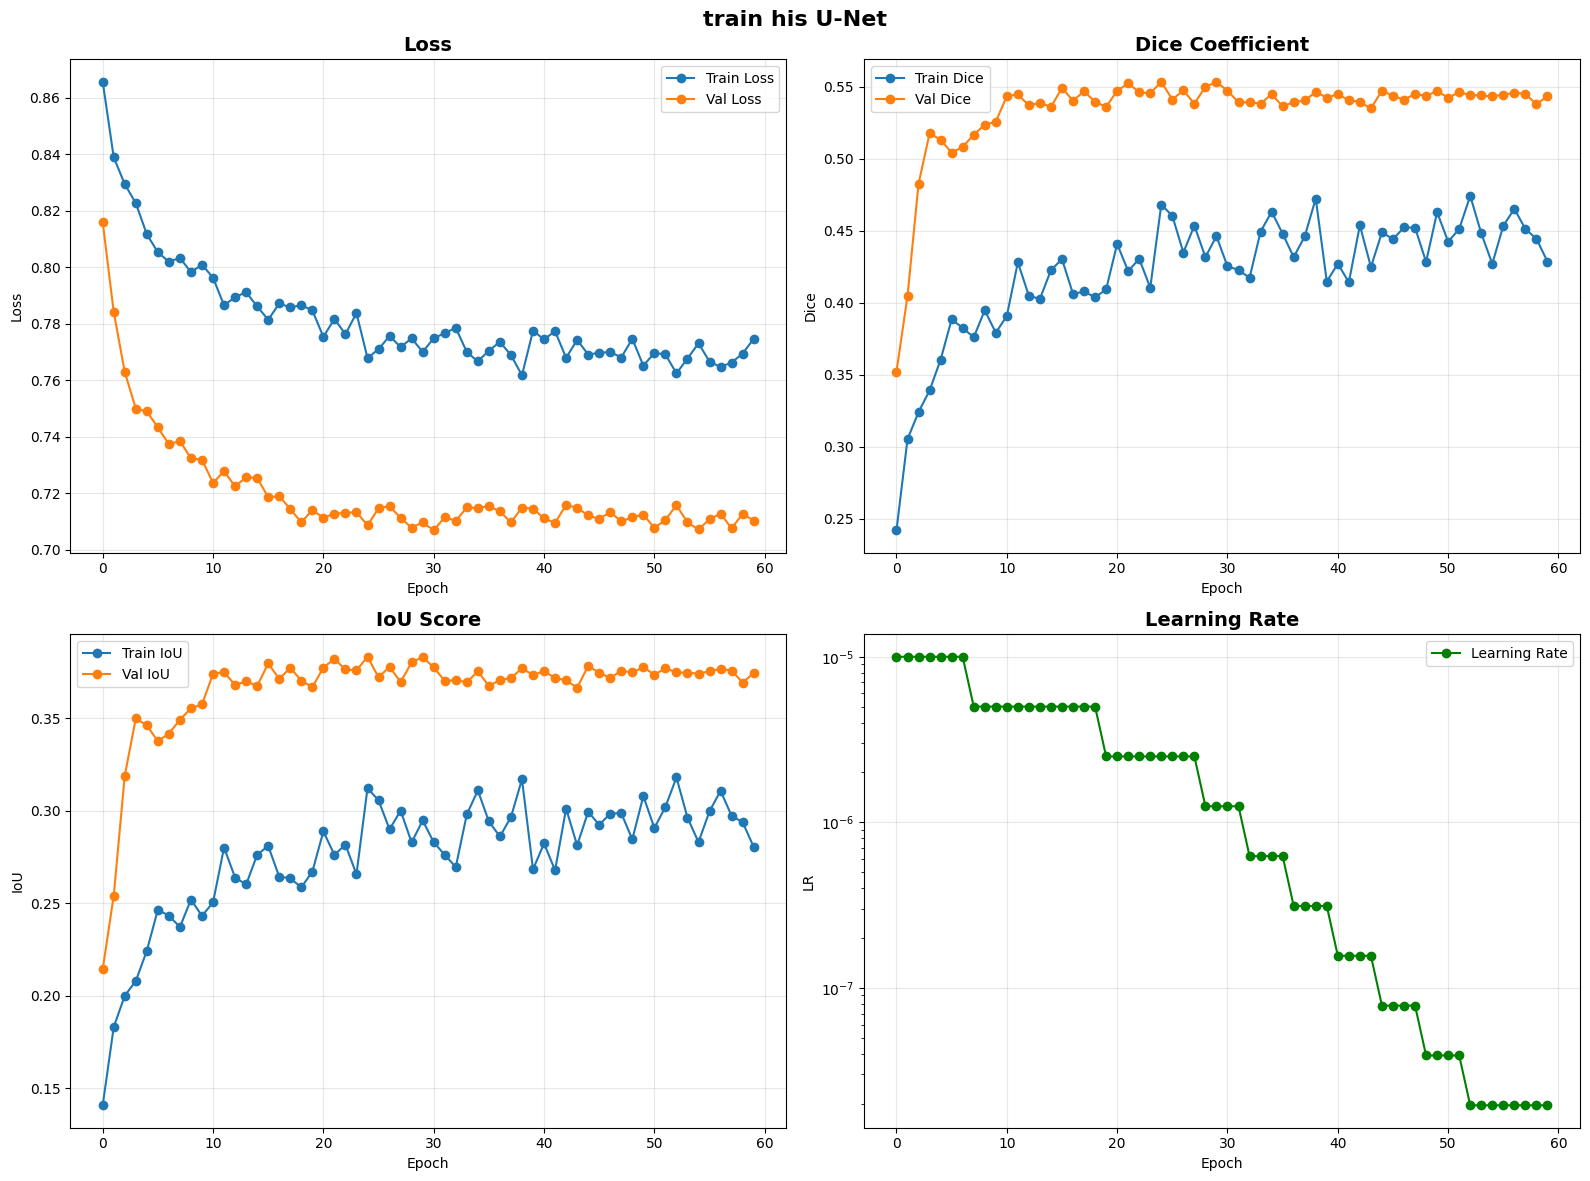

Train Loss:  [0.8657196044921875, 0.8389551430940628, 0.8294643819332123, 0.8227376997470855, 0.8117083668708801, 0.8053550332784652, 0.8020082354545593, 0.8033716350793838, 0.7982864022254944, 0.8009870558977127, 0.7963395357131958, 0.786552631855011, 0.7895038902759552, 0.7912062108516693, 0.7861974895000458, 0.7814597815275193, 0.7872338086366654, 0.7858323067426681, 0.7866218566894532, 0.7847874641418457, 0.7754275739192963, 0.7817621916532517, 0.7763741612434387, 0.7838463574647904, 0.7679253995418549, 0.7710466802120208, 0.7757383942604065, 0.7718025535345078, 0.7748975217342376, 0.7700828462839127, 0.7749109178781509, 0.7767124682664871, 0.7786036938428879, 0.7700454860925674, 0.7667114704847335, 0.7705510586500168, 0.773611631989479, 0.7689719378948212, 0.761794176697731, 0.7776099950075149, 0.7744895607233048, 0.7774212241172791, 0.7679762899875641, 0.7743411391973496, 0.769157099723816, 0.7697559595108032, 0.7700849056243897, 0.7681019395589829, 0.7747529357671737, 0.76521657

In [43]:
plot_training_history(history_resnet_unet_B)

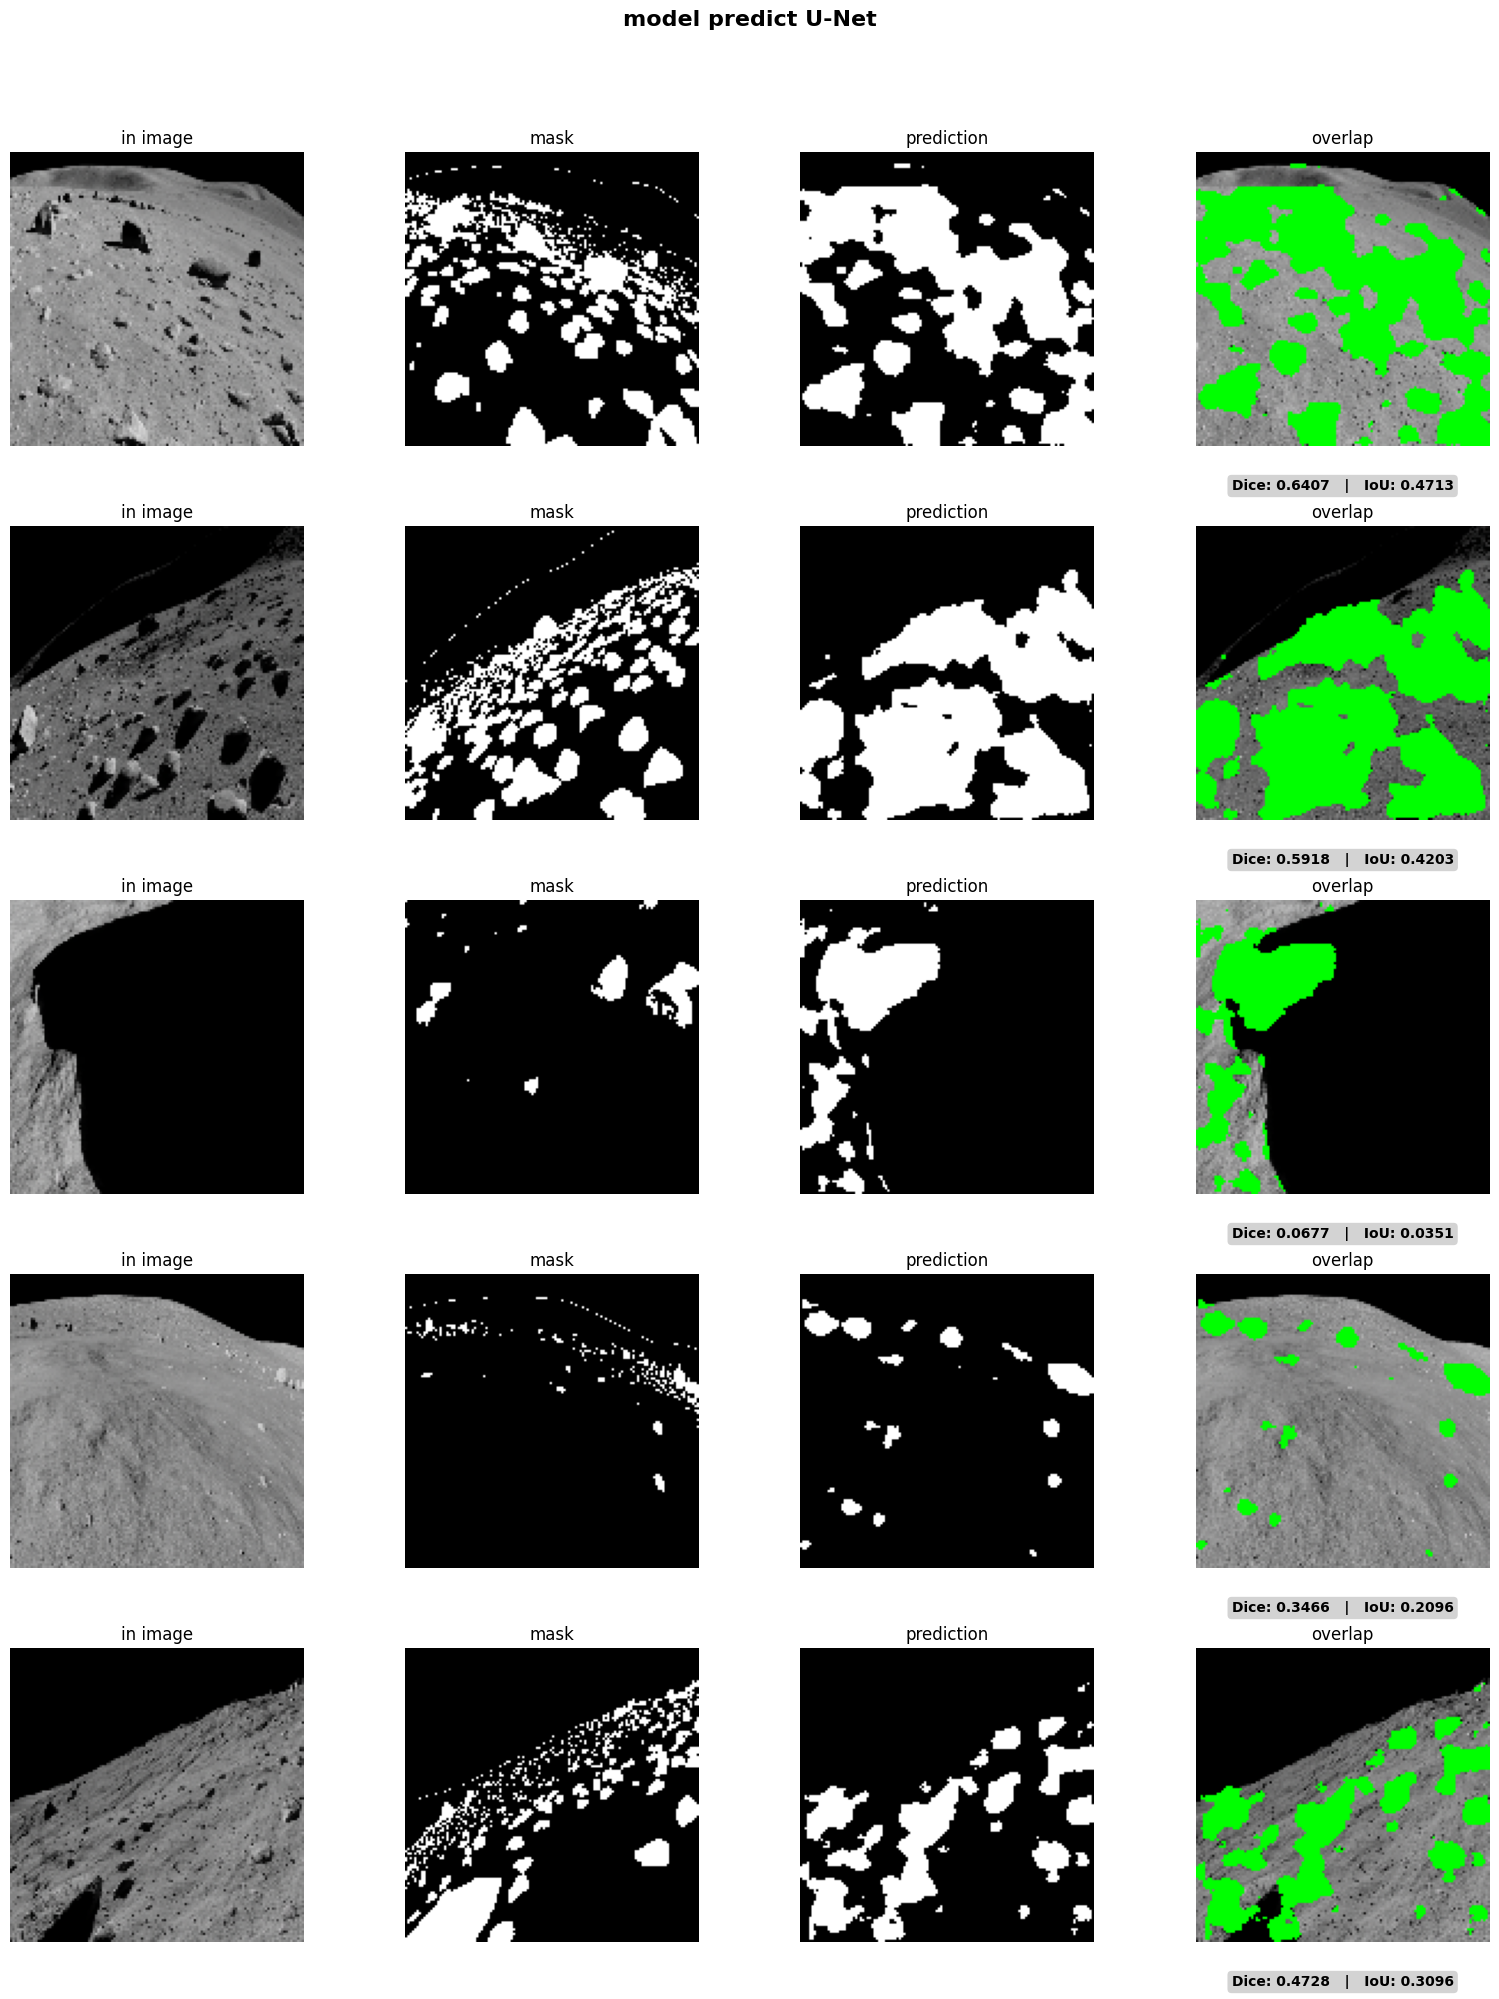

In [44]:
visualize_predictions(resnet_unetB, val_loader, device, num_samples=5)

In [48]:
def compare_models(simple_model, resnet_model, dataloader, device, num_samples=3, names=["U-Net", "ResNet-UNet"]):

    simple_model.eval()
    resnet_model.eval()

    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        simple_preds = simple_model(images)
        simple_preds = (simple_preds > 0.5).float()

        resnet_preds = resnet_model(images)
        resnet_preds = (resnet_preds > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    simple_preds = simple_preds.cpu()
    resnet_preds = resnet_preds.cpu()

    fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        if masks.dim() == 4:  # [B, 1, H, W]
          mask_true = masks[i, 0].numpy()
        elif masks.dim() == 3:  # [B, H, W]
          mask_true = masks[i].numpy()
        #mask_true = masks[i, 0].numpy()
        simple_pred = simple_preds[i, 0].numpy()
        resnet_pred = resnet_preds[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Initial', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(simple_pred, cmap='gray')
        simple_dice = dice_coefficient(simple_preds[i:i+1], masks[i:i+1])
        simple_iou = iou_score(simple_preds[i:i+1], masks[i:i+1])
        axes[i, 2].set_title(f'{names[0]} \nDice: {simple_dice:.3f} | IoU: {simple_iou:.3f}', fontsize=10)
        axes[i, 2].axis('off')

        axes[i, 3].imshow(resnet_pred, cmap='gray')
        resnet_dice = dice_coefficient(resnet_preds[i:i+1], masks[i:i+1])
        resnet_iou = iou_score(resnet_preds[i:i+1], masks[i:i+1])
        axes[i, 3].set_title(f'{names[1]}\nDice: {resnet_dice:.3f} | IoU: {resnet_iou:.3f}', fontsize=10)
        axes[i, 3].axis('off')

        diff = np.abs(simple_pred - resnet_pred)
        axes[i, 4].imshow(diff, cmap='hot')
        axes[i, 4].set_title('Difference\n(white = disagree)', fontsize=10)
        axes[i, 4].axis('off')

    plt.suptitle("model comparison " + names[0] + " and " + names[1], fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



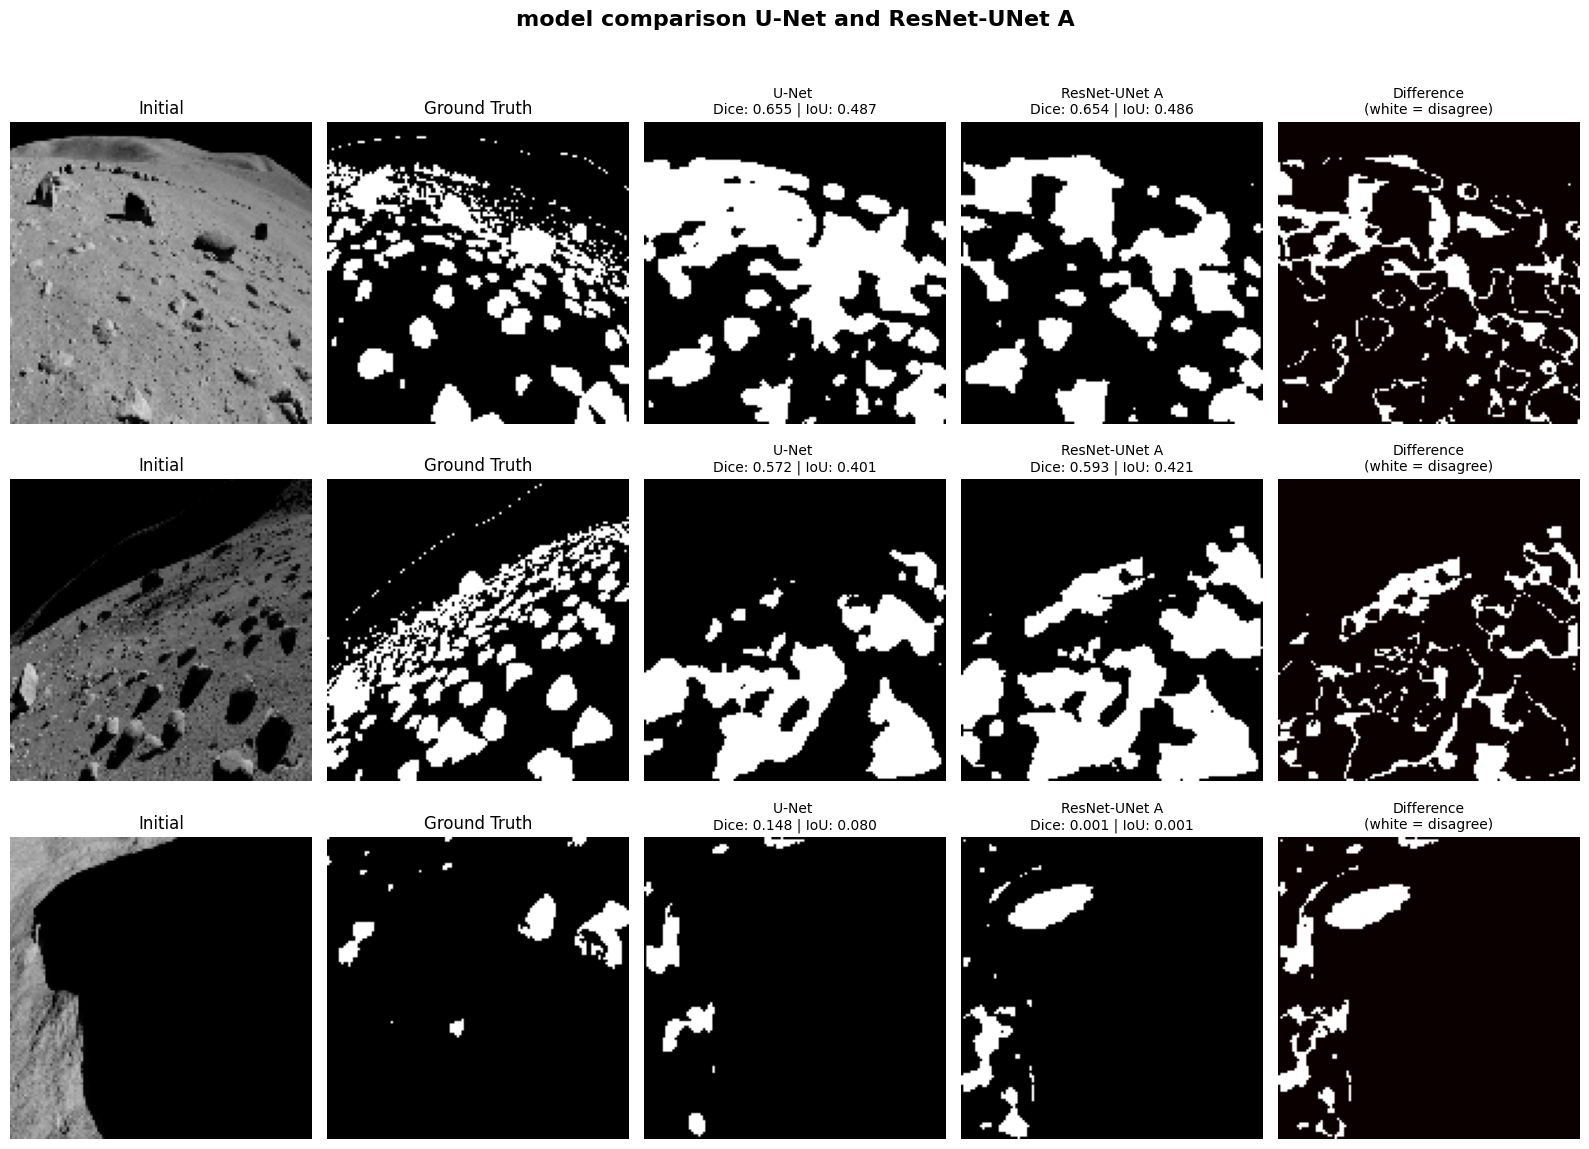

In [49]:
compare_models(unet_model, resnet_unetA, val_loader, device, num_samples=3, names=["U-Net", "ResNet-UNet A"])

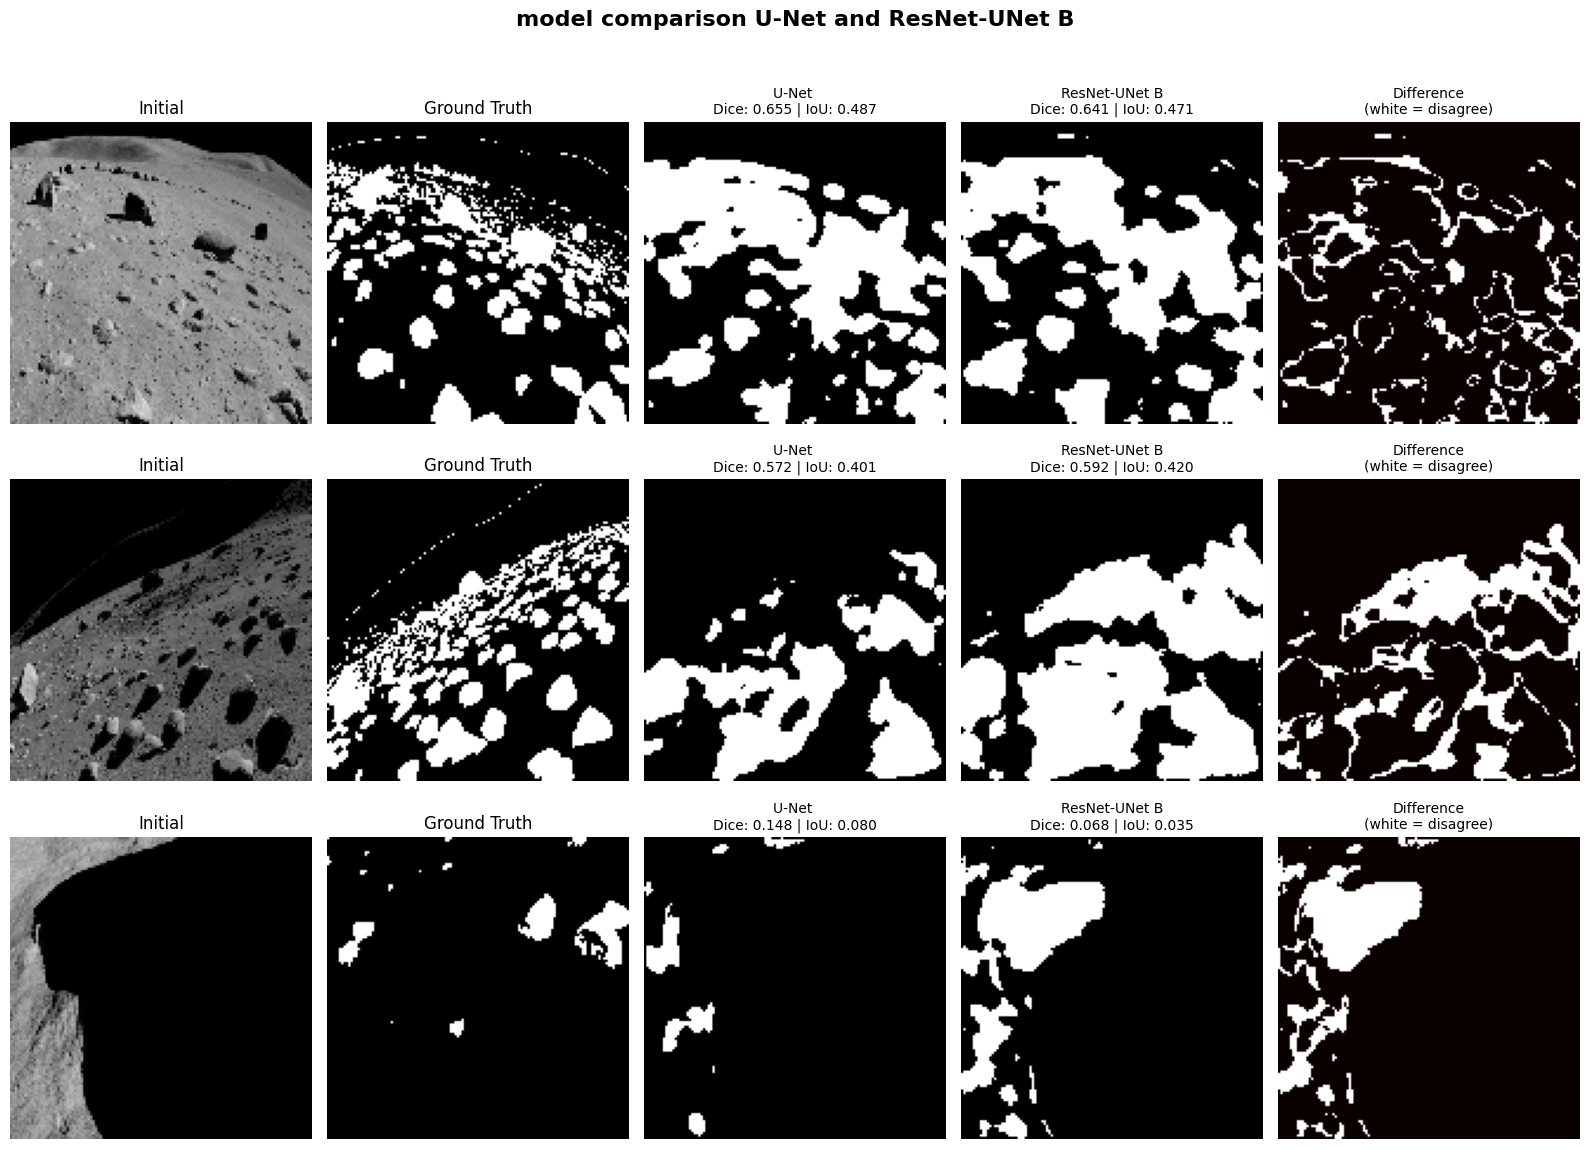

In [50]:
compare_models(unet_model, resnet_unetB, val_loader, device, num_samples=3, names=["U-Net", "ResNet-UNet B"])

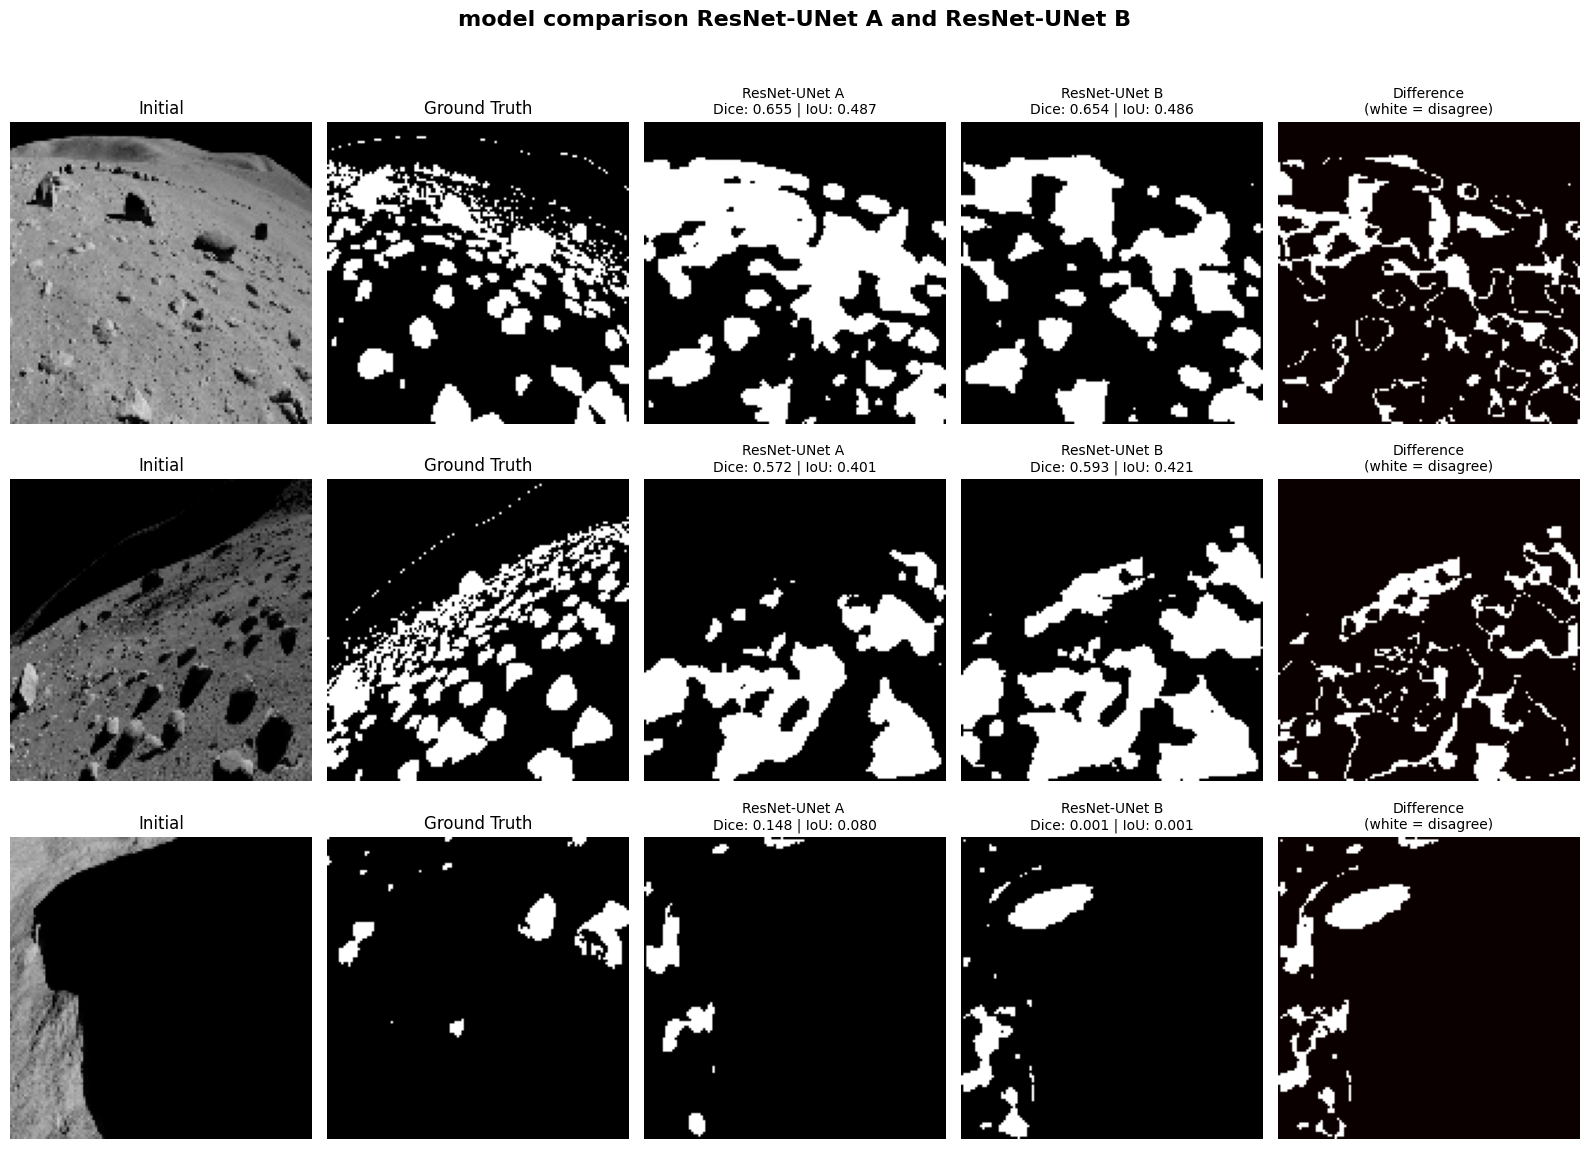

In [51]:
compare_models(unet_model, resnet_unetA, val_loader, device, num_samples=3, names=["ResNet-UNet A", "ResNet-UNet B"])

### Результат

| Конфигурация                | Всего параметров | Обучаемых |Val IoU | Val Dice |Val Pixel Acc|
|-----------------------------|------------------|-----------|---------|----------|-------------|
| Базовая U-Net               | 2.47M            | 2.47M     | **0.3666**     |**0.5355**        |**0.8806**|
| U-Net + Resnet с заморозкой | 4.66M            | 3.47M     | 0.3402     |0.5067|0.8614|
| U-Net + Resnet с разморозкой| 4.66M            | 4.66M     | 0.3426     |0.5084|0.8719|

**Вывод:**
Базовая модель Unet показала лучший результат по всем метрикам на валидации.

Это объясняется тем, что датасет "луна" включает только 100 изображений, на таком маленьком датасете предобученный бэкбон не адаптируется на нужном уровне, особоенно если признаки, обученные на другом домене, не релевантны на задаче сегментации лунного грунта и камней. В то же времяЮ U-net обучалась с нуля и специализировалась именно в вышеупомянутой задаче.

Если сравнивать модели с бэкбоном, то при разморозке энкодера модель показывает лучше результат, так как она смогла немного адаптироваться к домену.